In [1]:
#Using census data which contains data a person's age, education, marital status, and occupation (the features),
# we will try to predict whether or not the person earns more than 50,000 dollars a year (the target label).
# We will train a logistic regression model that, given an individual's information, outputs a number between 0 and 1—this 
# can be interpreted as the probability that the individual has an annual income of over 50,000 dollars.

# Solve a binary classification problem with Tensorflow Estimator function

import tensorflow as tf
import tensorflow.feature_column as fc 

import os
import sys

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
tf.enable_eager_execution()

In [3]:
# execute runtensormodel.bat
# download census dataset https://www.tensorflow.org/tutorials/estimators/linear
models_path = os.path.join(os.getcwd(), 'models')

sys.path.append(models_path)

In [4]:
print(models_path)

D:\tensorflow\models


In [5]:
from official.wide_deep import census_dataset
from official.wide_deep import census_main

census_dataset.download("/census_data/")

In [6]:
train_file = "/census_data/adult.data"
test_file = "/census_data/adult.test"

In [8]:
import pandas

train_df = pandas.read_csv(train_file, header = None, names = census_dataset._CSV_COLUMNS)
test_df = pandas.read_csv(test_file, header = None, names = census_dataset._CSV_COLUMNS)

train_df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [11]:
test_df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [9]:
# Approach 1 - for small problem, it's easy to make a tf.data.Dataset by slicing the pandas.DataFrame


def easy_input_function(df, label_key, num_epochs, shuffle, batch_size):
  label = df[label_key]
  ds = tf.data.Dataset.from_tensor_slices((dict(df),label))

  if shuffle:
    ds = ds.shuffle(10000)

  ds = ds.batch(batch_size).repeat(num_epochs)

  return ds

In [12]:
ds = easy_input_function(train_df, label_key='income_bracket', num_epochs=5, shuffle=True, batch_size=10)

for feature_batch, label_batch in ds.take(1):
  print('Some feature keys:', list(feature_batch.keys())[:5])
  print()
  print('A batch of Ages  :', feature_batch['age'])
  print()
  print('A batch of Labels:', label_batch )

Instructions for updating:
Colocations handled automatically by placer.


W0526 20:51:16.244782  2108 deprecation.py:323] From d:\Anaconda3\envs\pythongpu36\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py:532: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Some feature keys: ['age', 'workclass', 'fnlwgt', 'education', 'education_num']

A batch of Ages  : tf.Tensor([26 50 34 33 51 57 44 48 29 37], shape=(10,), dtype=int32)

A batch of Labels: tf.Tensor(
[b'<=50K' b'<=50K' b'<=50K' b'<=50K' b'<=50K' b'>50K' b'<=50K' b'<=50K'
 b'<=50K' b'<=50K'], shape=(10,), dtype=string)


In [13]:
# Approach 2 - for larger dataset problem

# When building a tf.estimator model, the input data is specified by using an input function (or input_fn).
# This builder function returns a tf.data.Dataset of batches of (features-dict, label) pairs. 
# The input builder function returns the following pair:

# features: A dict from feature names to Tensors or SparseTensors containing batches of features.
# labels: A Tensor containing batches of labels.

import inspect
print(inspect.getsource(census_dataset.input_fn))

def input_fn(data_file, num_epochs, shuffle, batch_size):
  """Generate an input function for the Estimator."""
  assert tf.gfile.Exists(data_file), (
      '%s not found. Please make sure you have run census_dataset.py and '
      'set the --data_dir argument to the correct path.' % data_file)

  def parse_csv(value):
    tf.logging.info('Parsing {}'.format(data_file))
    columns = tf.decode_csv(value, record_defaults=_CSV_COLUMN_DEFAULTS)
    features = dict(zip(_CSV_COLUMNS, columns))
    labels = features.pop('income_bracket')
    classes = tf.equal(labels, '>50K')  # binary classification
    return features, classes

  # Extract lines from input files using the Dataset API.
  dataset = tf.data.TextLineDataset(data_file)

  if shuffle:
    dataset = dataset.shuffle(buffer_size=_NUM_EXAMPLES['train'])

  dataset = dataset.map(parse_csv, num_parallel_calls=5)

  # We call repeat after shuffling, rather than before, to prevent separate
  # epochs from blending together.
  dataset = 

In [14]:
def input_fn(data_file, num_epochs, shuffle, batch_size):
  """Generate an input function for the Estimator."""
  assert tf.gfile.Exists(data_file), (
      '%s not found. Please make sure you have run census_dataset.py and '
      'set the --data_dir argument to the correct path.' % data_file)
       
  def parse_csv(value):
    tf.logging.info('Parsing {}'.format(data_file))
    columns = tf.decode_csv(value, record_defaults=_CSV_COLUMN_DEFAULTS)
    features = dict(zip(_CSV_COLUMNS, columns))
    labels = features.pop('income_bracket')
    classes = tf.equal(labels, '>50K')  # binary classification
    return features, classes

 # Extract lines from input files using the Dataset API.
  dataset = tf.data.TextLineDataset(data_file)


  if shuffle:
    dataset = dataset.shuffle(buffer_size=_NUM_EXAMPLES['train'])

  dataset = dataset.map(parse_csv, num_parallel_calls=5)

  # We call repeat after shuffling, rather than before, to prevent separate
  # epochs from blending together.
  dataset = dataset.repeat(num_epochs)
  dataset = dataset.batch(batch_size)
  return dataset


In [17]:
ds = census_dataset.input_fn(train_file, num_epochs=5, shuffle=True, batch_size=10)

for feature_batch, label_batch in ds.take(1):
  print('Feature keys:', list(feature_batch.keys())[:5])
  print()
  print('Age batch   :', feature_batch['age'])
  print()
  print('Label batch :', label_batch )

INFO:tensorflow:Parsing /census_data/adult.data


I0526 20:53:07.428725  2108 census_dataset.py:167] Parsing /census_data/adult.data


Feature keys: ['age', 'workclass', 'fnlwgt', 'education', 'education_num']

Age batch   : tf.Tensor([70 49 29 42 38 24 59 31 29 34], shape=(10,), dtype=int32)

Label batch : tf.Tensor([False False False  True False False False False False  True], shape=(10,), dtype=bool)


In [16]:
# Because Estimators expect an input_fn that takes no arguments, 
# we typically wrap configurable input function into an obejct with the expected signature.

import functools

train_inpf = functools.partial(census_dataset.input_fn, train_file, num_epochs=2, shuffle=True, batch_size=64)
test_inpf = functools.partial(census_dataset.input_fn, test_file, num_epochs=1, shuffle=False, batch_size=64)

In [18]:
age = fc.numeric_column('age')

In [21]:
age

NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)

In [22]:
# Example 1 - The simplest feature_column is numeric_column. 
#This indicates that a feature is a numeric value that should be input to the model directly

fc.input_layer(feature_batch, [age]).numpy()

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


W0526 20:54:05.750792  2108 deprecation.py:323] From d:\Anaconda3\envs\pythongpu36\lib\site-packages\tensorflow\python\feature_column\feature_column.py:205: NumericColumn._get_dense_tensor (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


W0526 20:54:05.754919  2108 deprecation.py:323] From d:\Anaconda3\envs\pythongpu36\lib\site-packages\tensorflow\python\feature_column\feature_column.py:2121: NumericColumn._transform_feature (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
Use tf.cast instead.


W0526 20:54:05.757433  2108 deprecation.py:323] From d:\Anaconda3\envs\pythongpu36\lib\site-packages\tensorflow\python\feature_column\feature_column_v2.py:2703: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


W0526 20:54:05.759879  2108 deprecation.py:323] From d:\Anaconda3\envs\pythongpu36\lib\site-packages\tensorflow\python\feature_column\feature_column.py:206: NumericColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


array([[70.],
       [49.],
       [29.],
       [42.],
       [38.],
       [24.],
       [59.],
       [31.],
       [29.],
       [34.]], dtype=float32)

In [23]:
#The model will use the feature_column definitions to build the model input. You can inspect the resulting output using the input_layer function:
fc.input_layer(feature_batch, [age]).numpy()

array([[70.],
       [49.],
       [29.],
       [42.],
       [38.],
       [24.],
       [59.],
       [31.],
       [29.],
       [34.]], dtype=float32)

In [24]:
classifier = tf.estimator.LinearClassifier(feature_columns=[age])
classifier.train(train_inpf)
result = classifier.evaluate(test_inpf)

INFO:tensorflow:Using default config.


I0526 20:55:57.393651  2108 estimator.py:1739] Using default config.


W0526 20:55:57.398399  2108 estimator.py:1760] Using temporary folder as model directory: C:\Users\user\AppData\Local\Temp\tmpm24ykljy


INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\user\\AppData\\Local\\Temp\\tmpm24ykljy', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000023E961D2BE0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0526 20:55:57.401094  2108 estimator.py:201] Using config: {'_model_dir': 'C:\\Users\\user\\AppData\\Local\\Temp\\tmpm24ykljy', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000023E961D2BE0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Parsing /census_data/adult.data


I0526 20:55:57.442373  2108 census_dataset.py:167] Parsing /census_data/adult.data


INFO:tensorflow:Calling model_fn.


I0526 20:55:57.540044  2108 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0526 20:55:58.065495  2108 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0526 20:55:58.068562  2108 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0526 20:55:59.265206  2108 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0526 20:55:59.702749  2108 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0526 20:55:59.733030  2108 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into C:\Users\user\AppData\Local\Temp\tmpm24ykljy\model.ckpt.


I0526 20:56:01.490481  2108 basic_session_run_hooks.py:594] Saving checkpoints for 0 into C:\Users\user\AppData\Local\Temp\tmpm24ykljy\model.ckpt.


INFO:tensorflow:loss = 44.36142, step = 0


I0526 20:56:05.539862  2108 basic_session_run_hooks.py:249] loss = 44.36142, step = 0


INFO:tensorflow:global_step/sec: 111.733


I0526 20:56:06.429706  2108 basic_session_run_hooks.py:680] global_step/sec: 111.733


INFO:tensorflow:loss = 38.046997, step = 100 (0.895 sec)


I0526 20:56:06.434715  2108 basic_session_run_hooks.py:247] loss = 38.046997, step = 100 (0.895 sec)


INFO:tensorflow:global_step/sec: 139.216


I0526 20:56:07.148016  2108 basic_session_run_hooks.py:680] global_step/sec: 139.216


INFO:tensorflow:loss = 27.483976, step = 200 (0.718 sec)


I0526 20:56:07.152449  2108 basic_session_run_hooks.py:247] loss = 27.483976, step = 200 (0.718 sec)


INFO:tensorflow:global_step/sec: 135.835


I0526 20:56:07.884202  2108 basic_session_run_hooks.py:680] global_step/sec: 135.835


INFO:tensorflow:loss = 37.025814, step = 300 (0.737 sec)


I0526 20:56:07.889061  2108 basic_session_run_hooks.py:247] loss = 37.025814, step = 300 (0.737 sec)


INFO:tensorflow:global_step/sec: 142.355


I0526 20:56:08.586669  2108 basic_session_run_hooks.py:680] global_step/sec: 142.355


INFO:tensorflow:loss = 33.29918, step = 400 (0.703 sec)


I0526 20:56:08.591670  2108 basic_session_run_hooks.py:247] loss = 33.29918, step = 400 (0.703 sec)


INFO:tensorflow:global_step/sec: 134.747


I0526 20:56:09.328798  2108 basic_session_run_hooks.py:680] global_step/sec: 134.747


INFO:tensorflow:loss = 36.18294, step = 500 (0.741 sec)


I0526 20:56:09.332730  2108 basic_session_run_hooks.py:247] loss = 36.18294, step = 500 (0.741 sec)


INFO:tensorflow:global_step/sec: 119.67


I0526 20:56:10.164428  2108 basic_session_run_hooks.py:680] global_step/sec: 119.67


INFO:tensorflow:loss = 28.310547, step = 600 (0.836 sec)


I0526 20:56:10.168500  2108 basic_session_run_hooks.py:247] loss = 28.310547, step = 600 (0.836 sec)


INFO:tensorflow:global_step/sec: 124.959


I0526 20:56:10.964693  2108 basic_session_run_hooks.py:680] global_step/sec: 124.959


INFO:tensorflow:loss = 35.85369, step = 700 (0.800 sec)


I0526 20:56:10.968569  2108 basic_session_run_hooks.py:247] loss = 35.85369, step = 700 (0.800 sec)


INFO:tensorflow:global_step/sec: 131.369


I0526 20:56:11.725906  2108 basic_session_run_hooks.py:680] global_step/sec: 131.369


INFO:tensorflow:loss = 37.94595, step = 800 (0.763 sec)


I0526 20:56:11.731384  2108 basic_session_run_hooks.py:247] loss = 37.94595, step = 800 (0.763 sec)


INFO:tensorflow:global_step/sec: 140.21


I0526 20:56:12.439123  2108 basic_session_run_hooks.py:680] global_step/sec: 140.21


INFO:tensorflow:loss = 35.16997, step = 900 (0.712 sec)


I0526 20:56:12.443409  2108 basic_session_run_hooks.py:247] loss = 35.16997, step = 900 (0.712 sec)


INFO:tensorflow:global_step/sec: 148.751


I0526 20:56:13.112386  2108 basic_session_run_hooks.py:680] global_step/sec: 148.751


INFO:tensorflow:loss = 36.396454, step = 1000 (0.672 sec)


I0526 20:56:13.115430  2108 basic_session_run_hooks.py:247] loss = 36.396454, step = 1000 (0.672 sec)


INFO:tensorflow:Saving checkpoints for 1018 into C:\Users\user\AppData\Local\Temp\tmpm24ykljy\model.ckpt.


I0526 20:56:13.871066  2108 basic_session_run_hooks.py:594] Saving checkpoints for 1018 into C:\Users\user\AppData\Local\Temp\tmpm24ykljy\model.ckpt.


INFO:tensorflow:Loss for final step: 19.058641.


I0526 20:56:14.652518  2108 estimator.py:359] Loss for final step: 19.058641.


INFO:tensorflow:Parsing /census_data/adult.test


I0526 20:56:14.698792  2108 census_dataset.py:167] Parsing /census_data/adult.test


INFO:tensorflow:Calling model_fn.


I0526 20:56:14.848573  2108 estimator.py:1111] Calling model_fn.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0526 20:56:15.458602  2108 deprecation.py:323] From d:\Anaconda3\envs\pythongpu36\lib\site-packages\tensorflow\python\ops\metrics_impl.py:2002: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0526 20:56:16.512512  2108 metrics_impl.py:783] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


W0526 20:56:16.571038  2108 metrics_impl.py:783] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


INFO:tensorflow:Done calling model_fn.


I0526 20:56:16.636317  2108 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-05-26T12:56:16Z


I0526 20:56:16.700116  2108 evaluation.py:257] Starting evaluation at 2019-05-26T12:56:16Z


INFO:tensorflow:Graph was finalized.


I0526 20:56:16.940351  2108 monitored_session.py:222] Graph was finalized.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


W0526 20:56:16.995820  2108 deprecation.py:323] From d:\Anaconda3\envs\pythongpu36\lib\site-packages\tensorflow\python\training\saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from C:\Users\user\AppData\Local\Temp\tmpm24ykljy\model.ckpt-1018


I0526 20:56:17.003868  2108 saver.py:1270] Restoring parameters from C:\Users\user\AppData\Local\Temp\tmpm24ykljy\model.ckpt-1018


INFO:tensorflow:Running local_init_op.


I0526 20:56:17.121123  2108 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0526 20:56:17.184314  2108 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-05-26-12:56:20


I0526 20:56:20.877582  2108 evaluation.py:277] Finished evaluation at 2019-05-26-12:56:20


INFO:tensorflow:Saving dict for global step 1018: accuracy = 0.74737424, accuracy_baseline = 0.76377374, auc = 0.6783566, auc_precision_recall = 0.31139174, average_loss = 0.5257012, global_step = 1018, label/mean = 0.23622628, loss = 33.564476, precision = 0.17675544, prediction/mean = 0.27091354, recall = 0.01898076


I0526 20:56:20.881383  2108 estimator.py:1979] Saving dict for global step 1018: accuracy = 0.74737424, accuracy_baseline = 0.76377374, auc = 0.6783566, auc_precision_recall = 0.31139174, average_loss = 0.5257012, global_step = 1018, label/mean = 0.23622628, loss = 33.564476, precision = 0.17675544, prediction/mean = 0.27091354, recall = 0.01898076


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1018: C:\Users\user\AppData\Local\Temp\tmpm24ykljy\model.ckpt-1018


I0526 20:56:23.781880  2108 estimator.py:2039] Saving 'checkpoint_path' summary for global step 1018: C:\Users\user\AppData\Local\Temp\tmpm24ykljy\model.ckpt-1018


In [25]:
clear_output()  # used for display in notebook
print(result)

{'accuracy': 0.74737424, 'accuracy_baseline': 0.76377374, 'auc': 0.6783566, 'auc_precision_recall': 0.31139174, 'average_loss': 0.5257012, 'label/mean': 0.23622628, 'loss': 33.564476, 'precision': 0.17675544, 'prediction/mean': 0.27091354, 'recall': 0.01898076, 'global_step': 1018}


In [26]:
# Example 2- define a NumericColumn for each continuous feature column that we want to use in the model:
education_num = tf.feature_column.numeric_column('education_num')
capital_gain = tf.feature_column.numeric_column('capital_gain')
capital_loss = tf.feature_column.numeric_column('capital_loss')
hours_per_week = tf.feature_column.numeric_column('hours_per_week')

my_numeric_columns = [age,education_num, capital_gain, capital_loss, hours_per_week]

fc.input_layer(feature_batch, my_numeric_columns).numpy()

array([[  70., 2228.,    0.,    9.,   24.],
       [  49.,    0., 1380.,   11.,   42.],
       [  29.,    0.,    0.,   13.,   40.],
       [  42.,    0.,    0.,   13.,   40.],
       [  38.,    0.,    0.,    9.,   40.],
       [  24.,    0.,    0.,    9.,   40.],
       [  59.,    0.,    0.,    9.,   45.],
       [  31.,    0.,    0.,    9.,   56.],
       [  29.,    0.,    0.,   10.,   25.],
       [  34.,    0.,    0.,   16.,   50.]], dtype=float32)

In [27]:
classifier = tf.estimator.LinearClassifier(feature_columns=my_numeric_columns)
classifier.train(train_inpf)

result = classifier.evaluate(test_inpf)

clear_output()

for key,value in sorted(result.items()):
  print('%s: %s' % (key, value))

accuracy: 0.7828757
accuracy_baseline: 0.76377374
auc: 0.69438577
auc_precision_recall: 0.5069668
average_loss: 1.0637271
global_step: 1018
label/mean: 0.23622628
loss: 67.91585
precision: 0.5755221
prediction/mean: 0.22773615
recall: 0.30811232


In [28]:
# Example 3 - Categorical columns
#If you know the set of all possible feature values of a column—and there are only a few of them—use categorical_column_with_vocabulary_list. 
# Each key in the list is assigned an auto-incremented ID starting from 0. For example, for the relationship column we can assign the feature string Husband to an integer ID of 0 and "Not-in-family" to 1, etc.
relationship = fc.categorical_column_with_vocabulary_list(
    'relationship',
    ['Husband', 'Not-in-family', 'Wife', 'Own-child', 'Unmarried', 'Other-relative'])

In [29]:
fc.input_layer(feature_batch, [age, fc.indicator_column(relationship)])

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


W0526 21:00:12.820671  2108 deprecation.py:323] From d:\Anaconda3\envs\pythongpu36\lib\site-packages\tensorflow\python\feature_column\feature_column.py:205: IndicatorColumn._get_dense_tensor (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


W0526 21:00:12.827227  2108 deprecation.py:323] From d:\Anaconda3\envs\pythongpu36\lib\site-packages\tensorflow\python\feature_column\feature_column.py:2121: IndicatorColumn._transform_feature (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


W0526 21:00:12.830474  2108 deprecation.py:323] From d:\Anaconda3\envs\pythongpu36\lib\site-packages\tensorflow\python\feature_column\feature_column_v2.py:4295: VocabularyListCategoricalColumn._get_sparse_tensors (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


W0526 21:00:12.837382  2108 deprecation.py:323] From d:\Anaconda3\envs\pythongpu36\lib\site-packages\tensorflow\python\feature_column\feature_column.py:2121: VocabularyListCategoricalColumn._transform_feature (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
Use tf.cast instead.


W0526 21:00:12.894781  2108 deprecation.py:323] From d:\Anaconda3\envs\pythongpu36\lib\site-packages\tensorflow\python\ops\lookup_ops.py:1137: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


W0526 21:00:12.917716  2108 deprecation.py:323] From d:\Anaconda3\envs\pythongpu36\lib\site-packages\tensorflow\python\feature_column\feature_column_v2.py:4266: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


W0526 21:00:12.922557  2108 deprecation.py:323] From d:\Anaconda3\envs\pythongpu36\lib\site-packages\tensorflow\python\feature_column\feature_column_v2.py:4321: VocabularyListCategoricalColumn._num_buckets (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


<tf.Tensor: id=4881, shape=(10, 7), dtype=float32, numpy=
array([[70.,  1.,  0.,  0.,  0.,  0.,  0.],
       [49.,  0.,  0.,  0.,  0.,  1.,  0.],
       [29.,  0.,  1.,  0.,  0.,  0.,  0.],
       [42.,  1.,  0.,  0.,  0.,  0.,  0.],
       [38.,  0.,  0.,  0.,  0.,  1.,  0.],
       [24.,  0.,  0.,  0.,  1.,  0.,  0.],
       [59.,  1.,  0.,  0.,  0.,  0.,  0.],
       [31.,  0.,  1.,  0.,  0.,  0.,  0.],
       [29.,  0.,  0.,  1.,  0.,  0.,  0.],
       [34.,  0.,  0.,  1.,  0.,  0.,  0.]], dtype=float32)>

In [31]:
my_categorical_columns = [age, fc.indicator_column(relationship)]
classifier = tf.estimator.LinearClassifier(feature_columns=my_categorical_columns)
classifier.train(train_inpf)

result = classifier.evaluate(test_inpf)

clear_output()

for key,value in sorted(result.items()):
  print('%s: %s' % (key, value))

accuracy: 0.74964684
accuracy_baseline: 0.76377374
auc: 0.8001521
auc_precision_recall: 0.43882233
average_loss: 0.42949122
global_step: 1018
label/mean: 0.23622628
loss: 27.421751
precision: 0.4257106
prediction/mean: 0.24534784
recall: 0.17134686


In [32]:
# Example 4 - if we don't know the set of possible values in advance, use the categorical_column_with_hash_bucket instead
occupation = tf.feature_column.categorical_column_with_hash_bucket(
    'occupation', hash_bucket_size=1000)

In [33]:
for item in feature_batch['occupation'].numpy():
    print(item.decode())

?
Handlers-cleaners
Prof-specialty
Prof-specialty
Other-service
Other-service
Craft-repair
Other-service
Sales
Prof-specialty


In [34]:
occupation_result = fc.input_layer(feature_batch, [fc.indicator_column(occupation)])

occupation_result.numpy().shape

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


W0526 21:03:30.662732  2108 deprecation.py:323] From d:\Anaconda3\envs\pythongpu36\lib\site-packages\tensorflow\python\feature_column\feature_column_v2.py:4295: HashedCategoricalColumn._get_sparse_tensors (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


W0526 21:03:30.668027  2108 deprecation.py:323] From d:\Anaconda3\envs\pythongpu36\lib\site-packages\tensorflow\python\feature_column\feature_column.py:2121: HashedCategoricalColumn._transform_feature (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


W0526 21:03:30.796991  2108 deprecation.py:323] From d:\Anaconda3\envs\pythongpu36\lib\site-packages\tensorflow\python\feature_column\feature_column_v2.py:4321: HashedCategoricalColumn._num_buckets (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


(10, 1000)

In [35]:
# It's easier to see the actual results if we take the tf.argmax over the hash_bucket_size dimension. Notice how any duplicate occupations are mapped to the same pseudo-random index
tf.argmax(occupation_result, axis=1).numpy()

array([ 65,  10, 979, 979, 527, 527, 466, 527, 631, 979], dtype=int64)

In [36]:
education = tf.feature_column.categorical_column_with_vocabulary_list(
    'education', [
        'Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
        'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
        '5th-6th', '10th', '1st-4th', 'Preschool', '12th'])

marital_status = tf.feature_column.categorical_column_with_vocabulary_list(
    'marital_status', [
        'Married-civ-spouse', 'Divorced', 'Married-spouse-absent',
        'Never-married', 'Separated', 'Married-AF-spouse', 'Widowed'])

workclass = tf.feature_column.categorical_column_with_vocabulary_list(
    'workclass', [
        'Self-emp-not-inc', 'Private', 'State-gov', 'Federal-gov',
        'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked'])


my_categorical_columns = [relationship, occupation, education, marital_status, workclass]

In [37]:
classifier = tf.estimator.LinearClassifier(feature_columns=my_numeric_columns+my_categorical_columns)
classifier.train(train_inpf)
result = classifier.evaluate(test_inpf)

clear_output()

for key,value in sorted(result.items()):
  print('%s: %s' % (key, value))

accuracy: 0.83274984
accuracy_baseline: 0.76377374
auc: 0.88578063
auc_precision_recall: 0.6996703
average_loss: 0.45830336
global_step: 1018
label/mean: 0.23622628
loss: 29.261322
precision: 0.6522093
prediction/mean: 0.2563204
recall: 0.625585


In [38]:
# Example 5 - Derived feature columns

In [39]:
# Learn the fine-grained correlation between income and each age group separately, we can leverage bucketization. Bucketization is a process of dividing the entire range of a continuous feature into a set of consecutive buckets, and then converting the original numerical feature into a bucket ID (as a categorical feature) depending on which bucket that value falls into.
# Define a bucketized_column over age as:
age_buckets = tf.feature_column.bucketized_column(
    age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])

In [40]:
fc.input_layer(feature_batch, [age, age_buckets]).numpy()

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


W0526 21:06:56.340802  2108 deprecation.py:323] From d:\Anaconda3\envs\pythongpu36\lib\site-packages\tensorflow\python\feature_column\feature_column.py:205: BucketizedColumn._get_dense_tensor (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


W0526 21:06:56.346604  2108 deprecation.py:323] From d:\Anaconda3\envs\pythongpu36\lib\site-packages\tensorflow\python\feature_column\feature_column.py:2121: BucketizedColumn._transform_feature (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


W0526 21:06:56.356637  2108 deprecation.py:323] From d:\Anaconda3\envs\pythongpu36\lib\site-packages\tensorflow\python\feature_column\feature_column.py:206: BucketizedColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


array([[70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [49.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [29.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [42.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [38.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [24.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [59.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [31.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [29.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [34.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],
      dtype=float32)

In [41]:
# Example 6 - Learn complex relationships with crossed column
# The correlation between education and the label (earning > 50,000 dollars) may be different for different occupations
education_x_occupation = tf.feature_column.crossed_column(
    ['education', 'occupation'], hash_bucket_size=1000)

In [42]:
age_buckets_x_education_x_occupation = tf.feature_column.crossed_column(
    [age_buckets, 'education', 'occupation'], hash_bucket_size=1000)

In [45]:
# Define logistic regression model 
import tempfile

base_columns = [
    education, marital_status, relationship, workclass, occupation,
    age_buckets,
]

crossed_columns = [
    tf.feature_column.crossed_column(
        ['education', 'occupation'], hash_bucket_size=1000),
    tf.feature_column.crossed_column(
        [age_buckets, 'education', 'occupation'], hash_bucket_size=1000),
]

In [46]:
model = tf.estimator.LinearClassifier(
    model_dir=tempfile.mkdtemp(), 
    feature_columns=base_columns + crossed_columns,
    optimizer=tf.train.FtrlOptimizer(learning_rate=0.1))

INFO:tensorflow:Using default config.


I0526 21:13:41.897118  2108 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\user\\AppData\\Local\\Temp\\tmpeqr5hrxs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000023EF988A9E8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0526 21:13:41.900101  2108 estimator.py:201] Using config: {'_model_dir': 'C:\\Users\\user\\AppData\\Local\\Temp\\tmpeqr5hrxs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000023EF988A9E8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [47]:
# Train and evaluate the model
train_inpf = functools.partial(census_dataset.input_fn, train_file, 
                               num_epochs=40, shuffle=True, batch_size=64)


In [48]:
model.train(train_inpf)


INFO:tensorflow:Parsing /census_data/adult.data


I0526 21:14:55.723307  2108 census_dataset.py:167] Parsing /census_data/adult.data


INFO:tensorflow:Calling model_fn.


I0526 21:14:55.816448  2108 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Done calling model_fn.


I0526 21:14:58.776626  2108 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0526 21:14:58.776626  2108 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0526 21:15:03.088716  2108 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0526 21:15:03.553223  2108 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0526 21:15:03.611980  2108 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into C:\Users\user\AppData\Local\Temp\tmpeqr5hrxs\model.ckpt.


I0526 21:15:09.959314  2108 basic_session_run_hooks.py:594] Saving checkpoints for 0 into C:\Users\user\AppData\Local\Temp\tmpeqr5hrxs\model.ckpt.


INFO:tensorflow:loss = 44.36142, step = 0


I0526 21:15:13.755774  2108 basic_session_run_hooks.py:249] loss = 44.36142, step = 0


INFO:tensorflow:global_step/sec: 26.3843


I0526 21:15:17.544903  2108 basic_session_run_hooks.py:680] global_step/sec: 26.3843


INFO:tensorflow:loss = 22.029617, step = 100 (3.793 sec)


I0526 21:15:17.549251  2108 basic_session_run_hooks.py:247] loss = 22.029617, step = 100 (3.793 sec)


INFO:tensorflow:global_step/sec: 31.0225


I0526 21:15:20.768374  2108 basic_session_run_hooks.py:680] global_step/sec: 31.0225


INFO:tensorflow:loss = 15.081858, step = 200 (3.224 sec)


I0526 21:15:20.772952  2108 basic_session_run_hooks.py:247] loss = 15.081858, step = 200 (3.224 sec)


INFO:tensorflow:global_step/sec: 31.0046


I0526 21:15:23.993697  2108 basic_session_run_hooks.py:680] global_step/sec: 31.0046


INFO:tensorflow:loss = 17.40056, step = 300 (3.225 sec)


I0526 21:15:23.997970  2108 basic_session_run_hooks.py:247] loss = 17.40056, step = 300 (3.225 sec)


INFO:tensorflow:global_step/sec: 31.1606


I0526 21:15:27.202875  2108 basic_session_run_hooks.py:680] global_step/sec: 31.1606


INFO:tensorflow:loss = 32.94435, step = 400 (3.210 sec)


I0526 21:15:27.208173  2108 basic_session_run_hooks.py:247] loss = 32.94435, step = 400 (3.210 sec)


INFO:tensorflow:global_step/sec: 32.3612


I0526 21:15:30.292994  2108 basic_session_run_hooks.py:680] global_step/sec: 32.3612


INFO:tensorflow:loss = 29.534418, step = 500 (3.090 sec)


I0526 21:15:30.297863  2108 basic_session_run_hooks.py:247] loss = 29.534418, step = 500 (3.090 sec)


INFO:tensorflow:global_step/sec: 31.9712


I0526 21:15:33.420806  2108 basic_session_run_hooks.py:680] global_step/sec: 31.9712


INFO:tensorflow:loss = 17.802979, step = 600 (3.128 sec)


I0526 21:15:33.425659  2108 basic_session_run_hooks.py:247] loss = 17.802979, step = 600 (3.128 sec)


INFO:tensorflow:global_step/sec: 34.8696


I0526 21:15:36.288635  2108 basic_session_run_hooks.py:680] global_step/sec: 34.8696


INFO:tensorflow:loss = 22.631824, step = 700 (2.867 sec)


I0526 21:15:36.292569  2108 basic_session_run_hooks.py:247] loss = 22.631824, step = 700 (2.867 sec)


INFO:tensorflow:global_step/sec: 31.3265


I0526 21:15:39.480822  2108 basic_session_run_hooks.py:680] global_step/sec: 31.3265


INFO:tensorflow:loss = 24.67685, step = 800 (3.192 sec)


I0526 21:15:39.484919  2108 basic_session_run_hooks.py:247] loss = 24.67685, step = 800 (3.192 sec)


INFO:tensorflow:global_step/sec: 34.1832


I0526 21:15:42.406239  2108 basic_session_run_hooks.py:680] global_step/sec: 34.1832


INFO:tensorflow:loss = 24.09615, step = 900 (2.926 sec)


I0526 21:15:42.411015  2108 basic_session_run_hooks.py:247] loss = 24.09615, step = 900 (2.926 sec)


INFO:tensorflow:global_step/sec: 33.169


I0526 21:15:45.421102  2108 basic_session_run_hooks.py:680] global_step/sec: 33.169


INFO:tensorflow:loss = 23.620367, step = 1000 (3.015 sec)


I0526 21:15:45.425597  2108 basic_session_run_hooks.py:247] loss = 23.620367, step = 1000 (3.015 sec)


INFO:tensorflow:global_step/sec: 31.176


I0526 21:15:48.628702  2108 basic_session_run_hooks.py:680] global_step/sec: 31.176


INFO:tensorflow:loss = 15.113428, step = 1100 (3.210 sec)


I0526 21:15:48.635387  2108 basic_session_run_hooks.py:247] loss = 15.113428, step = 1100 (3.210 sec)


INFO:tensorflow:global_step/sec: 33.8399


I0526 21:15:51.583796  2108 basic_session_run_hooks.py:680] global_step/sec: 33.8399


INFO:tensorflow:loss = 25.5184, step = 1200 (2.953 sec)


I0526 21:15:51.588175  2108 basic_session_run_hooks.py:247] loss = 25.5184, step = 1200 (2.953 sec)


INFO:tensorflow:global_step/sec: 30.5612


I0526 21:15:54.855920  2108 basic_session_run_hooks.py:680] global_step/sec: 30.5612


INFO:tensorflow:loss = 18.054153, step = 1300 (3.273 sec)


I0526 21:15:54.861607  2108 basic_session_run_hooks.py:247] loss = 18.054153, step = 1300 (3.273 sec)


INFO:tensorflow:global_step/sec: 32.5296


I0526 21:15:57.930043  2108 basic_session_run_hooks.py:680] global_step/sec: 32.5296


INFO:tensorflow:loss = 33.239227, step = 1400 (3.069 sec)


I0526 21:15:57.931042  2108 basic_session_run_hooks.py:247] loss = 33.239227, step = 1400 (3.069 sec)


INFO:tensorflow:global_step/sec: 32.2319


I0526 21:16:01.032559  2108 basic_session_run_hooks.py:680] global_step/sec: 32.2319


INFO:tensorflow:loss = 23.20086, step = 1500 (3.104 sec)


I0526 21:16:01.036173  2108 basic_session_run_hooks.py:247] loss = 23.20086, step = 1500 (3.104 sec)


INFO:tensorflow:global_step/sec: 31.2217


I0526 21:16:04.235456  2108 basic_session_run_hooks.py:680] global_step/sec: 31.2217


INFO:tensorflow:loss = 16.688921, step = 1600 (3.205 sec)


I0526 21:16:04.240580  2108 basic_session_run_hooks.py:247] loss = 16.688921, step = 1600 (3.205 sec)


INFO:tensorflow:global_step/sec: 32.3246


I0526 21:16:07.329079  2108 basic_session_run_hooks.py:680] global_step/sec: 32.3246


INFO:tensorflow:loss = 23.84251, step = 1700 (3.093 sec)


I0526 21:16:07.333489  2108 basic_session_run_hooks.py:247] loss = 23.84251, step = 1700 (3.093 sec)


INFO:tensorflow:global_step/sec: 30.9777


I0526 21:16:10.557205  2108 basic_session_run_hooks.py:680] global_step/sec: 30.9777


INFO:tensorflow:loss = 19.838968, step = 1800 (3.230 sec)


I0526 21:16:10.563291  2108 basic_session_run_hooks.py:247] loss = 19.838968, step = 1800 (3.230 sec)


INFO:tensorflow:global_step/sec: 31.6473


I0526 21:16:13.717029  2108 basic_session_run_hooks.py:680] global_step/sec: 31.6473


INFO:tensorflow:loss = 23.209848, step = 1900 (3.158 sec)


I0526 21:16:13.721493  2108 basic_session_run_hooks.py:247] loss = 23.209848, step = 1900 (3.158 sec)


INFO:tensorflow:global_step/sec: 33.2331


I0526 21:16:16.726076  2108 basic_session_run_hooks.py:680] global_step/sec: 33.2331


INFO:tensorflow:loss = 17.341566, step = 2000 (3.009 sec)


I0526 21:16:16.730192  2108 basic_session_run_hooks.py:247] loss = 17.341566, step = 2000 (3.009 sec)


INFO:tensorflow:global_step/sec: 29.5568


I0526 21:16:20.109386  2108 basic_session_run_hooks.py:680] global_step/sec: 29.5568


INFO:tensorflow:loss = 18.12873, step = 2100 (3.384 sec)


I0526 21:16:20.114405  2108 basic_session_run_hooks.py:247] loss = 18.12873, step = 2100 (3.384 sec)


INFO:tensorflow:global_step/sec: 30.5395


I0526 21:16:23.383835  2108 basic_session_run_hooks.py:680] global_step/sec: 30.5395


INFO:tensorflow:loss = 22.685349, step = 2200 (3.275 sec)


I0526 21:16:23.389511  2108 basic_session_run_hooks.py:247] loss = 22.685349, step = 2200 (3.275 sec)


INFO:tensorflow:global_step/sec: 31.1504


I0526 21:16:26.594063  2108 basic_session_run_hooks.py:680] global_step/sec: 31.1504


INFO:tensorflow:loss = 18.75387, step = 2300 (3.209 sec)


I0526 21:16:26.598091  2108 basic_session_run_hooks.py:247] loss = 18.75387, step = 2300 (3.209 sec)


INFO:tensorflow:global_step/sec: 31.3897


I0526 21:16:29.779826  2108 basic_session_run_hooks.py:680] global_step/sec: 31.3897


INFO:tensorflow:loss = 17.711292, step = 2400 (3.187 sec)


I0526 21:16:29.785286  2108 basic_session_run_hooks.py:247] loss = 17.711292, step = 2400 (3.187 sec)


INFO:tensorflow:global_step/sec: 30.8471


I0526 21:16:33.021617  2108 basic_session_run_hooks.py:680] global_step/sec: 30.8471


INFO:tensorflow:loss = 24.817608, step = 2500 (3.237 sec)


I0526 21:16:33.022616  2108 basic_session_run_hooks.py:247] loss = 24.817608, step = 2500 (3.237 sec)


INFO:tensorflow:global_step/sec: 29.4362


I0526 21:16:36.419784  2108 basic_session_run_hooks.py:680] global_step/sec: 29.4362


INFO:tensorflow:loss = 25.510744, step = 2600 (3.401 sec)


I0526 21:16:36.423523  2108 basic_session_run_hooks.py:247] loss = 25.510744, step = 2600 (3.401 sec)


INFO:tensorflow:global_step/sec: 31.6295


I0526 21:16:39.580400  2108 basic_session_run_hooks.py:680] global_step/sec: 31.6295


INFO:tensorflow:loss = 22.241314, step = 2700 (3.160 sec)


I0526 21:16:39.583830  2108 basic_session_run_hooks.py:247] loss = 22.241314, step = 2700 (3.160 sec)


INFO:tensorflow:global_step/sec: 33.1326


I0526 21:16:42.598576  2108 basic_session_run_hooks.py:680] global_step/sec: 33.1326


INFO:tensorflow:loss = 17.772167, step = 2800 (3.019 sec)


I0526 21:16:42.602825  2108 basic_session_run_hooks.py:247] loss = 17.772167, step = 2800 (3.019 sec)


INFO:tensorflow:global_step/sec: 32.3024


I0526 21:16:45.694324  2108 basic_session_run_hooks.py:680] global_step/sec: 32.3024


INFO:tensorflow:loss = 18.551489, step = 2900 (3.097 sec)


I0526 21:16:45.700157  2108 basic_session_run_hooks.py:247] loss = 18.551489, step = 2900 (3.097 sec)


INFO:tensorflow:global_step/sec: 31.4038


I0526 21:16:48.878652  2108 basic_session_run_hooks.py:680] global_step/sec: 31.4038


INFO:tensorflow:loss = 23.445694, step = 3000 (3.184 sec)


I0526 21:16:48.883887  2108 basic_session_run_hooks.py:247] loss = 23.445694, step = 3000 (3.184 sec)


INFO:tensorflow:global_step/sec: 29.8023


I0526 21:16:52.235090  2108 basic_session_run_hooks.py:680] global_step/sec: 29.8023


INFO:tensorflow:loss = 23.851389, step = 3100 (3.355 sec)


I0526 21:16:52.239218  2108 basic_session_run_hooks.py:247] loss = 23.851389, step = 3100 (3.355 sec)


INFO:tensorflow:global_step/sec: 31.2067


I0526 21:16:55.438531  2108 basic_session_run_hooks.py:680] global_step/sec: 31.2067


INFO:tensorflow:loss = 31.06274, step = 3200 (3.204 sec)


I0526 21:16:55.442786  2108 basic_session_run_hooks.py:247] loss = 31.06274, step = 3200 (3.204 sec)


INFO:tensorflow:global_step/sec: 30.2615


I0526 21:16:58.743058  2108 basic_session_run_hooks.py:680] global_step/sec: 30.2615


INFO:tensorflow:loss = 21.362137, step = 3300 (3.305 sec)


I0526 21:16:58.748206  2108 basic_session_run_hooks.py:247] loss = 21.362137, step = 3300 (3.305 sec)


INFO:tensorflow:global_step/sec: 30.8173


I0526 21:17:01.987988  2108 basic_session_run_hooks.py:680] global_step/sec: 30.8173


INFO:tensorflow:loss = 20.91404, step = 3400 (3.269 sec)


I0526 21:17:02.017158  2108 basic_session_run_hooks.py:247] loss = 20.91404, step = 3400 (3.269 sec)


INFO:tensorflow:global_step/sec: 32.1419


I0526 21:17:05.099192  2108 basic_session_run_hooks.py:680] global_step/sec: 32.1419


INFO:tensorflow:loss = 32.981537, step = 3500 (3.087 sec)


I0526 21:17:05.104023  2108 basic_session_run_hooks.py:247] loss = 32.981537, step = 3500 (3.087 sec)


INFO:tensorflow:global_step/sec: 31.1696


I0526 21:17:08.307450  2108 basic_session_run_hooks.py:680] global_step/sec: 31.1696


INFO:tensorflow:loss = 24.232473, step = 3600 (3.208 sec)


I0526 21:17:08.311542  2108 basic_session_run_hooks.py:247] loss = 24.232473, step = 3600 (3.208 sec)


INFO:tensorflow:global_step/sec: 31.0361


I0526 21:17:11.529503  2108 basic_session_run_hooks.py:680] global_step/sec: 31.0361


INFO:tensorflow:loss = 17.530684, step = 3700 (3.222 sec)


I0526 21:17:11.533893  2108 basic_session_run_hooks.py:247] loss = 17.530684, step = 3700 (3.222 sec)


INFO:tensorflow:global_step/sec: 30.5246


I0526 21:17:14.805547  2108 basic_session_run_hooks.py:680] global_step/sec: 30.5246


INFO:tensorflow:loss = 24.136559, step = 3800 (3.276 sec)


I0526 21:17:14.809697  2108 basic_session_run_hooks.py:247] loss = 24.136559, step = 3800 (3.276 sec)


INFO:tensorflow:global_step/sec: 33.4732


I0526 21:17:17.793008  2108 basic_session_run_hooks.py:680] global_step/sec: 33.4732


INFO:tensorflow:loss = 18.05064, step = 3900 (2.989 sec)


I0526 21:17:17.798663  2108 basic_session_run_hooks.py:247] loss = 18.05064, step = 3900 (2.989 sec)


INFO:tensorflow:global_step/sec: 35.5022


I0526 21:17:20.609739  2108 basic_session_run_hooks.py:680] global_step/sec: 35.5022


INFO:tensorflow:loss = 28.363852, step = 4000 (2.815 sec)


I0526 21:17:20.614096  2108 basic_session_run_hooks.py:247] loss = 28.363852, step = 4000 (2.815 sec)


INFO:tensorflow:global_step/sec: 30.5506


I0526 21:17:23.882996  2108 basic_session_run_hooks.py:680] global_step/sec: 30.5506


INFO:tensorflow:loss = 25.023727, step = 4100 (3.273 sec)


I0526 21:17:23.887593  2108 basic_session_run_hooks.py:247] loss = 25.023727, step = 4100 (3.273 sec)


INFO:tensorflow:global_step/sec: 34.2324


I0526 21:17:26.804209  2108 basic_session_run_hooks.py:680] global_step/sec: 34.2324


INFO:tensorflow:loss = 19.849781, step = 4200 (2.922 sec)


I0526 21:17:26.809451  2108 basic_session_run_hooks.py:247] loss = 19.849781, step = 4200 (2.922 sec)


INFO:tensorflow:global_step/sec: 31.6726


I0526 21:17:29.961508  2108 basic_session_run_hooks.py:680] global_step/sec: 31.6726


INFO:tensorflow:loss = 26.16589, step = 4300 (3.157 sec)


I0526 21:17:29.965992  2108 basic_session_run_hooks.py:247] loss = 26.16589, step = 4300 (3.157 sec)


INFO:tensorflow:global_step/sec: 31.1403


I0526 21:17:33.172779  2108 basic_session_run_hooks.py:680] global_step/sec: 31.1403


INFO:tensorflow:loss = 22.012264, step = 4400 (3.211 sec)


I0526 21:17:33.177183  2108 basic_session_run_hooks.py:247] loss = 22.012264, step = 4400 (3.211 sec)


INFO:tensorflow:global_step/sec: 30.8722


I0526 21:17:36.412942  2108 basic_session_run_hooks.py:680] global_step/sec: 30.8722


INFO:tensorflow:loss = 24.765162, step = 4500 (3.240 sec)


I0526 21:17:36.417089  2108 basic_session_run_hooks.py:247] loss = 24.765162, step = 4500 (3.240 sec)


INFO:tensorflow:global_step/sec: 30.278


I0526 21:17:39.715670  2108 basic_session_run_hooks.py:680] global_step/sec: 30.278


INFO:tensorflow:loss = 28.670124, step = 4600 (3.303 sec)


I0526 21:17:39.719958  2108 basic_session_run_hooks.py:247] loss = 28.670124, step = 4600 (3.303 sec)


INFO:tensorflow:global_step/sec: 31.2669


I0526 21:17:42.912948  2108 basic_session_run_hooks.py:680] global_step/sec: 31.2669


INFO:tensorflow:loss = 20.705212, step = 4700 (3.198 sec)


I0526 21:17:42.918324  2108 basic_session_run_hooks.py:247] loss = 20.705212, step = 4700 (3.198 sec)


INFO:tensorflow:global_step/sec: 32.2816


I0526 21:17:46.010689  2108 basic_session_run_hooks.py:680] global_step/sec: 32.2816


INFO:tensorflow:loss = 12.914315, step = 4800 (3.097 sec)


I0526 21:17:46.014879  2108 basic_session_run_hooks.py:247] loss = 12.914315, step = 4800 (3.097 sec)


INFO:tensorflow:global_step/sec: 31.1002


I0526 21:17:49.226100  2108 basic_session_run_hooks.py:680] global_step/sec: 31.1002


INFO:tensorflow:loss = 17.4967, step = 4900 (3.215 sec)


I0526 21:17:49.230242  2108 basic_session_run_hooks.py:247] loss = 17.4967, step = 4900 (3.215 sec)


INFO:tensorflow:global_step/sec: 31.934


I0526 21:17:52.357563  2108 basic_session_run_hooks.py:680] global_step/sec: 31.934


INFO:tensorflow:loss = 35.569736, step = 5000 (3.132 sec)


I0526 21:17:52.362550  2108 basic_session_run_hooks.py:247] loss = 35.569736, step = 5000 (3.132 sec)


INFO:tensorflow:global_step/sec: 32.7421


I0526 21:17:55.411731  2108 basic_session_run_hooks.py:680] global_step/sec: 32.7421


INFO:tensorflow:loss = 14.289352, step = 5100 (3.054 sec)


I0526 21:17:55.416371  2108 basic_session_run_hooks.py:247] loss = 14.289352, step = 5100 (3.054 sec)


INFO:tensorflow:global_step/sec: 31.3546


I0526 21:17:58.602061  2108 basic_session_run_hooks.py:680] global_step/sec: 31.3546


INFO:tensorflow:loss = 30.283695, step = 5200 (3.190 sec)


I0526 21:17:58.605897  2108 basic_session_run_hooks.py:247] loss = 30.283695, step = 5200 (3.190 sec)


INFO:tensorflow:global_step/sec: 31.422


I0526 21:18:01.783546  2108 basic_session_run_hooks.py:680] global_step/sec: 31.422


INFO:tensorflow:loss = 20.562717, step = 5300 (3.182 sec)


I0526 21:18:01.788207  2108 basic_session_run_hooks.py:247] loss = 20.562717, step = 5300 (3.182 sec)


INFO:tensorflow:global_step/sec: 31.5115


I0526 21:18:04.956986  2108 basic_session_run_hooks.py:680] global_step/sec: 31.5115


INFO:tensorflow:loss = 25.718239, step = 5400 (3.174 sec)


I0526 21:18:04.961988  2108 basic_session_run_hooks.py:247] loss = 25.718239, step = 5400 (3.174 sec)


INFO:tensorflow:global_step/sec: 32.7261


I0526 21:18:08.012652  2108 basic_session_run_hooks.py:680] global_step/sec: 32.7261


INFO:tensorflow:loss = 21.197521, step = 5500 (3.054 sec)


I0526 21:18:08.015769  2108 basic_session_run_hooks.py:247] loss = 21.197521, step = 5500 (3.054 sec)


INFO:tensorflow:global_step/sec: 32.6001


I0526 21:18:11.080123  2108 basic_session_run_hooks.py:680] global_step/sec: 32.6001


INFO:tensorflow:loss = 19.150837, step = 5600 (3.070 sec)


I0526 21:18:11.085482  2108 basic_session_run_hooks.py:247] loss = 19.150837, step = 5600 (3.070 sec)


INFO:tensorflow:global_step/sec: 30.3795


I0526 21:18:14.372817  2108 basic_session_run_hooks.py:680] global_step/sec: 30.3795


INFO:tensorflow:loss = 21.089436, step = 5700 (3.292 sec)


I0526 21:18:14.377180  2108 basic_session_run_hooks.py:247] loss = 21.089436, step = 5700 (3.292 sec)


INFO:tensorflow:global_step/sec: 31.8132


I0526 21:18:17.515164  2108 basic_session_run_hooks.py:680] global_step/sec: 31.8132


INFO:tensorflow:loss = 17.320105, step = 5800 (3.142 sec)


I0526 21:18:17.518795  2108 basic_session_run_hooks.py:247] loss = 17.320105, step = 5800 (3.142 sec)


INFO:tensorflow:global_step/sec: 32.2137


I0526 21:18:20.619435  2108 basic_session_run_hooks.py:680] global_step/sec: 32.2137


INFO:tensorflow:loss = 20.410519, step = 5900 (3.105 sec)


I0526 21:18:20.623853  2108 basic_session_run_hooks.py:247] loss = 20.410519, step = 5900 (3.105 sec)


INFO:tensorflow:global_step/sec: 33.2317


I0526 21:18:23.628611  2108 basic_session_run_hooks.py:680] global_step/sec: 33.2317


INFO:tensorflow:loss = 20.399162, step = 6000 (3.009 sec)


I0526 21:18:23.633302  2108 basic_session_run_hooks.py:247] loss = 20.399162, step = 6000 (3.009 sec)


INFO:tensorflow:global_step/sec: 30.0035


I0526 21:18:26.961554  2108 basic_session_run_hooks.py:680] global_step/sec: 30.0035


INFO:tensorflow:loss = 25.118645, step = 6100 (3.333 sec)


I0526 21:18:26.966547  2108 basic_session_run_hooks.py:247] loss = 25.118645, step = 6100 (3.333 sec)


INFO:tensorflow:global_step/sec: 33.6441


I0526 21:18:29.934839  2108 basic_session_run_hooks.py:680] global_step/sec: 33.6441


INFO:tensorflow:loss = 27.146317, step = 6200 (2.972 sec)


I0526 21:18:29.938120  2108 basic_session_run_hooks.py:247] loss = 27.146317, step = 6200 (2.972 sec)


INFO:tensorflow:global_step/sec: 33.9922


I0526 21:18:32.875695  2108 basic_session_run_hooks.py:680] global_step/sec: 33.9922


INFO:tensorflow:loss = 22.423157, step = 6300 (2.942 sec)


I0526 21:18:32.879698  2108 basic_session_run_hooks.py:247] loss = 22.423157, step = 6300 (2.942 sec)


INFO:tensorflow:global_step/sec: 31.8152


I0526 21:18:36.018849  2108 basic_session_run_hooks.py:680] global_step/sec: 31.8152


INFO:tensorflow:loss = 16.260666, step = 6400 (3.143 sec)


I0526 21:18:36.022396  2108 basic_session_run_hooks.py:247] loss = 16.260666, step = 6400 (3.143 sec)


INFO:tensorflow:global_step/sec: 32.3348


I0526 21:18:39.111490  2108 basic_session_run_hooks.py:680] global_step/sec: 32.3348


INFO:tensorflow:loss = 16.14589, step = 6500 (3.093 sec)


I0526 21:18:39.115585  2108 basic_session_run_hooks.py:247] loss = 16.14589, step = 6500 (3.093 sec)


INFO:tensorflow:global_step/sec: 33.5768


I0526 21:18:42.089733  2108 basic_session_run_hooks.py:680] global_step/sec: 33.5768


INFO:tensorflow:loss = 33.997147, step = 6600 (2.980 sec)


I0526 21:18:42.095589  2108 basic_session_run_hooks.py:247] loss = 33.997147, step = 6600 (2.980 sec)


INFO:tensorflow:global_step/sec: 34.2359


I0526 21:18:45.010645  2108 basic_session_run_hooks.py:680] global_step/sec: 34.2359


INFO:tensorflow:loss = 24.498835, step = 6700 (2.918 sec)


I0526 21:18:45.013637  2108 basic_session_run_hooks.py:247] loss = 24.498835, step = 6700 (2.918 sec)


INFO:tensorflow:global_step/sec: 34.8769


I0526 21:18:47.877869  2108 basic_session_run_hooks.py:680] global_step/sec: 34.8769


INFO:tensorflow:loss = 14.118871, step = 6800 (2.868 sec)


I0526 21:18:47.881164  2108 basic_session_run_hooks.py:247] loss = 14.118871, step = 6800 (2.868 sec)


INFO:tensorflow:global_step/sec: 35.9383


I0526 21:18:50.660413  2108 basic_session_run_hooks.py:680] global_step/sec: 35.9383


INFO:tensorflow:loss = 25.377388, step = 6900 (2.782 sec)


I0526 21:18:50.663201  2108 basic_session_run_hooks.py:247] loss = 25.377388, step = 6900 (2.782 sec)


INFO:tensorflow:global_step/sec: 33.4336


I0526 21:18:53.651419  2108 basic_session_run_hooks.py:680] global_step/sec: 33.4336


INFO:tensorflow:loss = 20.127476, step = 7000 (2.994 sec)


I0526 21:18:53.657114  2108 basic_session_run_hooks.py:247] loss = 20.127476, step = 7000 (2.994 sec)


INFO:tensorflow:global_step/sec: 33.8492


I0526 21:18:56.606697  2108 basic_session_run_hooks.py:680] global_step/sec: 33.8492


INFO:tensorflow:loss = 20.428322, step = 7100 (2.954 sec)


I0526 21:18:56.610923  2108 basic_session_run_hooks.py:247] loss = 20.428322, step = 7100 (2.954 sec)


INFO:tensorflow:global_step/sec: 41.2946


I0526 21:18:59.028318  2108 basic_session_run_hooks.py:680] global_step/sec: 41.2946


INFO:tensorflow:loss = 23.387611, step = 7200 (2.420 sec)


I0526 21:18:59.031337  2108 basic_session_run_hooks.py:247] loss = 23.387611, step = 7200 (2.420 sec)


INFO:tensorflow:global_step/sec: 38.5626


I0526 21:19:01.620504  2108 basic_session_run_hooks.py:680] global_step/sec: 38.5626


INFO:tensorflow:loss = 19.15841, step = 7300 (2.593 sec)


I0526 21:19:01.624734  2108 basic_session_run_hooks.py:247] loss = 19.15841, step = 7300 (2.593 sec)


INFO:tensorflow:global_step/sec: 31.9786


I0526 21:19:04.747596  2108 basic_session_run_hooks.py:680] global_step/sec: 31.9786


INFO:tensorflow:loss = 19.765926, step = 7400 (3.137 sec)


I0526 21:19:04.762067  2108 basic_session_run_hooks.py:247] loss = 19.765926, step = 7400 (3.137 sec)


INFO:tensorflow:global_step/sec: 35.0317


I0526 21:19:07.602154  2108 basic_session_run_hooks.py:680] global_step/sec: 35.0317


INFO:tensorflow:loss = 18.903389, step = 7500 (2.844 sec)


I0526 21:19:07.605602  2108 basic_session_run_hooks.py:247] loss = 18.903389, step = 7500 (2.844 sec)


INFO:tensorflow:global_step/sec: 33.4869


I0526 21:19:10.588397  2108 basic_session_run_hooks.py:680] global_step/sec: 33.4869


INFO:tensorflow:loss = 23.366648, step = 7600 (2.987 sec)


I0526 21:19:10.592644  2108 basic_session_run_hooks.py:247] loss = 23.366648, step = 7600 (2.987 sec)


INFO:tensorflow:global_step/sec: 31.3197


I0526 21:19:13.781276  2108 basic_session_run_hooks.py:680] global_step/sec: 31.3197


INFO:tensorflow:loss = 25.529877, step = 7700 (3.193 sec)


I0526 21:19:13.785392  2108 basic_session_run_hooks.py:247] loss = 25.529877, step = 7700 (3.193 sec)


INFO:tensorflow:global_step/sec: 30.3087


I0526 21:19:17.080658  2108 basic_session_run_hooks.py:680] global_step/sec: 30.3087


INFO:tensorflow:loss = 25.067936, step = 7800 (3.300 sec)


I0526 21:19:17.085692  2108 basic_session_run_hooks.py:247] loss = 25.067936, step = 7800 (3.300 sec)


INFO:tensorflow:global_step/sec: 32.3614


I0526 21:19:20.170761  2108 basic_session_run_hooks.py:680] global_step/sec: 32.3614


INFO:tensorflow:loss = 22.550198, step = 7900 (3.089 sec)


I0526 21:19:20.174684  2108 basic_session_run_hooks.py:247] loss = 22.550198, step = 7900 (3.089 sec)


INFO:tensorflow:global_step/sec: 32.3303


I0526 21:19:23.263839  2108 basic_session_run_hooks.py:680] global_step/sec: 32.3303


INFO:tensorflow:loss = 16.930275, step = 8000 (3.094 sec)


I0526 21:19:23.268682  2108 basic_session_run_hooks.py:247] loss = 16.930275, step = 8000 (3.094 sec)


INFO:tensorflow:global_step/sec: 34.9472


I0526 21:19:26.125301  2108 basic_session_run_hooks.py:680] global_step/sec: 34.9472


INFO:tensorflow:loss = 19.155952, step = 8100 (2.860 sec)


I0526 21:19:26.128411  2108 basic_session_run_hooks.py:247] loss = 19.155952, step = 8100 (2.860 sec)


INFO:tensorflow:global_step/sec: 32.8864


I0526 21:19:29.166068  2108 basic_session_run_hooks.py:680] global_step/sec: 32.8864


INFO:tensorflow:loss = 25.763046, step = 8200 (3.042 sec)


I0526 21:19:29.170051  2108 basic_session_run_hooks.py:247] loss = 25.763046, step = 8200 (3.042 sec)


INFO:tensorflow:global_step/sec: 32.0221


I0526 21:19:32.288908  2108 basic_session_run_hooks.py:680] global_step/sec: 32.0221


INFO:tensorflow:loss = 21.29206, step = 8300 (3.123 sec)


I0526 21:19:32.293426  2108 basic_session_run_hooks.py:247] loss = 21.29206, step = 8300 (3.123 sec)


INFO:tensorflow:global_step/sec: 30.4676


I0526 21:19:35.571079  2108 basic_session_run_hooks.py:680] global_step/sec: 30.4676


INFO:tensorflow:loss = 28.027533, step = 8400 (3.283 sec)


I0526 21:19:35.576264  2108 basic_session_run_hooks.py:247] loss = 28.027533, step = 8400 (3.283 sec)


INFO:tensorflow:global_step/sec: 31.2249


I0526 21:19:38.773653  2108 basic_session_run_hooks.py:680] global_step/sec: 31.2249


INFO:tensorflow:loss = 27.546263, step = 8500 (3.199 sec)


I0526 21:19:38.778672  2108 basic_session_run_hooks.py:247] loss = 27.546263, step = 8500 (3.199 sec)


INFO:tensorflow:global_step/sec: 31.3532


I0526 21:19:41.963119  2108 basic_session_run_hooks.py:680] global_step/sec: 31.3532


INFO:tensorflow:loss = 23.373148, step = 8600 (3.192 sec)


I0526 21:19:41.968106  2108 basic_session_run_hooks.py:247] loss = 23.373148, step = 8600 (3.192 sec)


INFO:tensorflow:global_step/sec: 29.1425


I0526 21:19:45.394538  2108 basic_session_run_hooks.py:680] global_step/sec: 29.1425


INFO:tensorflow:loss = 22.379826, step = 8700 (3.432 sec)


I0526 21:19:45.399764  2108 basic_session_run_hooks.py:247] loss = 22.379826, step = 8700 (3.432 sec)


INFO:tensorflow:global_step/sec: 30.7571


I0526 21:19:48.645821  2108 basic_session_run_hooks.py:680] global_step/sec: 30.7571


INFO:tensorflow:loss = 16.509007, step = 8800 (3.251 sec)


I0526 21:19:48.650820  2108 basic_session_run_hooks.py:247] loss = 16.509007, step = 8800 (3.251 sec)


INFO:tensorflow:global_step/sec: 30.8965


I0526 21:19:51.882431  2108 basic_session_run_hooks.py:680] global_step/sec: 30.8965


INFO:tensorflow:loss = 19.959011, step = 8900 (3.236 sec)


I0526 21:19:51.886990  2108 basic_session_run_hooks.py:247] loss = 19.959011, step = 8900 (3.236 sec)


INFO:tensorflow:global_step/sec: 31.8529


I0526 21:19:55.021862  2108 basic_session_run_hooks.py:680] global_step/sec: 31.8529


INFO:tensorflow:loss = 28.650856, step = 9000 (3.139 sec)


I0526 21:19:55.025848  2108 basic_session_run_hooks.py:247] loss = 28.650856, step = 9000 (3.139 sec)


INFO:tensorflow:global_step/sec: 32.6749


I0526 21:19:58.082318  2108 basic_session_run_hooks.py:680] global_step/sec: 32.6749


INFO:tensorflow:loss = 16.630993, step = 9100 (3.061 sec)


I0526 21:19:58.086871  2108 basic_session_run_hooks.py:247] loss = 16.630993, step = 9100 (3.061 sec)


INFO:tensorflow:global_step/sec: 31.4548


I0526 21:20:01.261482  2108 basic_session_run_hooks.py:680] global_step/sec: 31.4548


INFO:tensorflow:loss = 21.907585, step = 9200 (3.180 sec)


I0526 21:20:01.266438  2108 basic_session_run_hooks.py:247] loss = 21.907585, step = 9200 (3.180 sec)


INFO:tensorflow:global_step/sec: 32.4036


I0526 21:20:04.347562  2108 basic_session_run_hooks.py:680] global_step/sec: 32.4036


INFO:tensorflow:loss = 23.708292, step = 9300 (3.085 sec)


I0526 21:20:04.351308  2108 basic_session_run_hooks.py:247] loss = 23.708292, step = 9300 (3.085 sec)


INFO:tensorflow:global_step/sec: 31.336


I0526 21:20:07.538782  2108 basic_session_run_hooks.py:680] global_step/sec: 31.336


INFO:tensorflow:loss = 16.897541, step = 9400 (3.191 sec)


I0526 21:20:07.542735  2108 basic_session_run_hooks.py:247] loss = 16.897541, step = 9400 (3.191 sec)


INFO:tensorflow:global_step/sec: 31.7362


I0526 21:20:10.689761  2108 basic_session_run_hooks.py:680] global_step/sec: 31.7362


INFO:tensorflow:loss = 25.780598, step = 9500 (3.151 sec)


I0526 21:20:10.693653  2108 basic_session_run_hooks.py:247] loss = 25.780598, step = 9500 (3.151 sec)


INFO:tensorflow:global_step/sec: 33.315


I0526 21:20:13.691412  2108 basic_session_run_hooks.py:680] global_step/sec: 33.315


INFO:tensorflow:loss = 17.746618, step = 9600 (3.002 sec)


I0526 21:20:13.695876  2108 basic_session_run_hooks.py:247] loss = 17.746618, step = 9600 (3.002 sec)


INFO:tensorflow:global_step/sec: 30.3758


I0526 21:20:16.983511  2108 basic_session_run_hooks.py:680] global_step/sec: 30.3758


INFO:tensorflow:loss = 29.368282, step = 9700 (3.292 sec)


I0526 21:20:16.987760  2108 basic_session_run_hooks.py:247] loss = 29.368282, step = 9700 (3.292 sec)


INFO:tensorflow:global_step/sec: 29.9153


I0526 21:20:20.326277  2108 basic_session_run_hooks.py:680] global_step/sec: 29.9153


INFO:tensorflow:loss = 24.438559, step = 9800 (3.344 sec)


I0526 21:20:20.331403  2108 basic_session_run_hooks.py:247] loss = 24.438559, step = 9800 (3.344 sec)


INFO:tensorflow:global_step/sec: 30.006


I0526 21:20:23.658941  2108 basic_session_run_hooks.py:680] global_step/sec: 30.006


INFO:tensorflow:loss = 18.265917, step = 9900 (3.333 sec)


I0526 21:20:23.664268  2108 basic_session_run_hooks.py:247] loss = 18.265917, step = 9900 (3.333 sec)


INFO:tensorflow:global_step/sec: 31.9702


I0526 21:20:26.786853  2108 basic_session_run_hooks.py:680] global_step/sec: 31.9702


INFO:tensorflow:loss = 17.513073, step = 10000 (3.126 sec)


I0526 21:20:26.790951  2108 basic_session_run_hooks.py:247] loss = 17.513073, step = 10000 (3.126 sec)


INFO:tensorflow:global_step/sec: 30.8538


I0526 21:20:30.027947  2108 basic_session_run_hooks.py:680] global_step/sec: 30.8538


INFO:tensorflow:loss = 15.913797, step = 10100 (3.242 sec)


I0526 21:20:30.032248  2108 basic_session_run_hooks.py:247] loss = 15.913797, step = 10100 (3.242 sec)


INFO:tensorflow:global_step/sec: 29.8772


I0526 21:20:33.374981  2108 basic_session_run_hooks.py:680] global_step/sec: 29.8772


INFO:tensorflow:loss = 25.412579, step = 10200 (3.346 sec)


I0526 21:20:33.378684  2108 basic_session_run_hooks.py:247] loss = 25.412579, step = 10200 (3.346 sec)


INFO:tensorflow:global_step/sec: 34.0892


I0526 21:20:36.308466  2108 basic_session_run_hooks.py:680] global_step/sec: 34.0892


INFO:tensorflow:loss = 21.054255, step = 10300 (2.934 sec)


I0526 21:20:36.313152  2108 basic_session_run_hooks.py:247] loss = 21.054255, step = 10300 (2.934 sec)


INFO:tensorflow:global_step/sec: 32.2634


I0526 21:20:39.407954  2108 basic_session_run_hooks.py:680] global_step/sec: 32.2634


INFO:tensorflow:loss = 26.133478, step = 10400 (3.099 sec)


I0526 21:20:39.412414  2108 basic_session_run_hooks.py:247] loss = 26.133478, step = 10400 (3.099 sec)


INFO:tensorflow:global_step/sec: 31.3478


I0526 21:20:42.597967  2108 basic_session_run_hooks.py:680] global_step/sec: 31.3478


INFO:tensorflow:loss = 25.808594, step = 10500 (3.192 sec)


I0526 21:20:42.604231  2108 basic_session_run_hooks.py:247] loss = 25.808594, step = 10500 (3.192 sec)


INFO:tensorflow:global_step/sec: 33.5133


I0526 21:20:45.581857  2108 basic_session_run_hooks.py:680] global_step/sec: 33.5133


INFO:tensorflow:loss = 19.501488, step = 10600 (2.982 sec)


I0526 21:20:45.586514  2108 basic_session_run_hooks.py:247] loss = 19.501488, step = 10600 (2.982 sec)


INFO:tensorflow:global_step/sec: 30.1208


I0526 21:20:48.901824  2108 basic_session_run_hooks.py:680] global_step/sec: 30.1208


INFO:tensorflow:loss = 18.19599, step = 10700 (3.320 sec)


I0526 21:20:48.906730  2108 basic_session_run_hooks.py:247] loss = 18.19599, step = 10700 (3.320 sec)


INFO:tensorflow:global_step/sec: 32.2607


I0526 21:20:52.001574  2108 basic_session_run_hooks.py:680] global_step/sec: 32.2607


INFO:tensorflow:loss = 15.184305, step = 10800 (3.099 sec)


I0526 21:20:52.005947  2108 basic_session_run_hooks.py:247] loss = 15.184305, step = 10800 (3.099 sec)


INFO:tensorflow:global_step/sec: 31.4541


I0526 21:20:55.180811  2108 basic_session_run_hooks.py:680] global_step/sec: 31.4541


INFO:tensorflow:loss = 17.835968, step = 10900 (3.179 sec)


I0526 21:20:55.185195  2108 basic_session_run_hooks.py:247] loss = 17.835968, step = 10900 (3.179 sec)


INFO:tensorflow:global_step/sec: 32.7315


I0526 21:20:58.236966  2108 basic_session_run_hooks.py:680] global_step/sec: 32.7315


INFO:tensorflow:loss = 21.00441, step = 11000 (3.055 sec)


I0526 21:20:58.239959  2108 basic_session_run_hooks.py:247] loss = 21.00441, step = 11000 (3.055 sec)


INFO:tensorflow:global_step/sec: 30.8601


I0526 21:21:01.477396  2108 basic_session_run_hooks.py:680] global_step/sec: 30.8601


INFO:tensorflow:loss = 17.695084, step = 11100 (3.242 sec)


I0526 21:21:01.482162  2108 basic_session_run_hooks.py:247] loss = 17.695084, step = 11100 (3.242 sec)


INFO:tensorflow:global_step/sec: 32.3851


I0526 21:21:04.564233  2108 basic_session_run_hooks.py:680] global_step/sec: 32.3851


INFO:tensorflow:loss = 17.09808, step = 11200 (3.087 sec)


I0526 21:21:04.569009  2108 basic_session_run_hooks.py:247] loss = 17.09808, step = 11200 (3.087 sec)


INFO:tensorflow:global_step/sec: 30.6346


I0526 21:21:07.828513  2108 basic_session_run_hooks.py:680] global_step/sec: 30.6346


INFO:tensorflow:loss = 17.720741, step = 11300 (3.279 sec)


I0526 21:21:07.848417  2108 basic_session_run_hooks.py:247] loss = 17.720741, step = 11300 (3.279 sec)


INFO:tensorflow:global_step/sec: 31.173


I0526 21:21:11.036416  2108 basic_session_run_hooks.py:680] global_step/sec: 31.173


INFO:tensorflow:loss = 19.082752, step = 11400 (3.194 sec)


I0526 21:21:11.042428  2108 basic_session_run_hooks.py:247] loss = 19.082752, step = 11400 (3.194 sec)


INFO:tensorflow:global_step/sec: 33.5636


I0526 21:21:14.015838  2108 basic_session_run_hooks.py:680] global_step/sec: 33.5636


INFO:tensorflow:loss = 28.548027, step = 11500 (2.978 sec)


I0526 21:21:14.020600  2108 basic_session_run_hooks.py:247] loss = 28.548027, step = 11500 (2.978 sec)


INFO:tensorflow:global_step/sec: 32.2343


I0526 21:21:17.118122  2108 basic_session_run_hooks.py:680] global_step/sec: 32.2343


INFO:tensorflow:loss = 22.136852, step = 11600 (3.102 sec)


I0526 21:21:17.122518  2108 basic_session_run_hooks.py:247] loss = 22.136852, step = 11600 (3.102 sec)


INFO:tensorflow:global_step/sec: 34.5957


I0526 21:21:20.008657  2108 basic_session_run_hooks.py:680] global_step/sec: 34.5957


INFO:tensorflow:loss = 28.243013, step = 11700 (2.891 sec)


I0526 21:21:20.013465  2108 basic_session_run_hooks.py:247] loss = 28.243013, step = 11700 (2.891 sec)


INFO:tensorflow:global_step/sec: 32.2055


I0526 21:21:23.113720  2108 basic_session_run_hooks.py:680] global_step/sec: 32.2055


INFO:tensorflow:loss = 20.12098, step = 11800 (3.104 sec)


I0526 21:21:23.117856  2108 basic_session_run_hooks.py:247] loss = 20.12098, step = 11800 (3.104 sec)


INFO:tensorflow:global_step/sec: 30.5706


I0526 21:21:26.384831  2108 basic_session_run_hooks.py:680] global_step/sec: 30.5706


INFO:tensorflow:loss = 18.461739, step = 11900 (3.271 sec)


I0526 21:21:26.389139  2108 basic_session_run_hooks.py:247] loss = 18.461739, step = 11900 (3.271 sec)


INFO:tensorflow:global_step/sec: 30.5465


I0526 21:21:29.658529  2108 basic_session_run_hooks.py:680] global_step/sec: 30.5465


INFO:tensorflow:loss = 20.21236, step = 12000 (3.274 sec)


I0526 21:21:29.662827  2108 basic_session_run_hooks.py:247] loss = 20.21236, step = 12000 (3.274 sec)


INFO:tensorflow:global_step/sec: 32.4789


I0526 21:21:32.737447  2108 basic_session_run_hooks.py:680] global_step/sec: 32.4789


INFO:tensorflow:loss = 25.599297, step = 12100 (3.078 sec)


I0526 21:21:32.741122  2108 basic_session_run_hooks.py:247] loss = 25.599297, step = 12100 (3.078 sec)


INFO:tensorflow:global_step/sec: 35.4739


I0526 21:21:35.556423  2108 basic_session_run_hooks.py:680] global_step/sec: 35.4739


INFO:tensorflow:loss = 24.089317, step = 12200 (2.818 sec)


I0526 21:21:35.559399  2108 basic_session_run_hooks.py:247] loss = 24.089317, step = 12200 (2.818 sec)


INFO:tensorflow:global_step/sec: 33.2269


I0526 21:21:38.566036  2108 basic_session_run_hooks.py:680] global_step/sec: 33.2269


INFO:tensorflow:loss = 22.104176, step = 12300 (3.012 sec)


I0526 21:21:38.571063  2108 basic_session_run_hooks.py:247] loss = 22.104176, step = 12300 (3.012 sec)


INFO:tensorflow:global_step/sec: 30.0068


I0526 21:21:41.898619  2108 basic_session_run_hooks.py:680] global_step/sec: 30.0068


INFO:tensorflow:loss = 12.281291, step = 12400 (3.332 sec)


I0526 21:21:41.903436  2108 basic_session_run_hooks.py:247] loss = 12.281291, step = 12400 (3.332 sec)


INFO:tensorflow:global_step/sec: 33.6838


I0526 21:21:44.867404  2108 basic_session_run_hooks.py:680] global_step/sec: 33.6838


INFO:tensorflow:loss = 26.0969, step = 12500 (2.969 sec)


I0526 21:21:44.872905  2108 basic_session_run_hooks.py:247] loss = 26.0969, step = 12500 (2.969 sec)


INFO:tensorflow:global_step/sec: 35.5974


I0526 21:21:47.677602  2108 basic_session_run_hooks.py:680] global_step/sec: 35.5974


INFO:tensorflow:loss = 13.755973, step = 12600 (2.807 sec)


I0526 21:21:47.680344  2108 basic_session_run_hooks.py:247] loss = 13.755973, step = 12600 (2.807 sec)


INFO:tensorflow:global_step/sec: 36.4295


I0526 21:21:50.421633  2108 basic_session_run_hooks.py:680] global_step/sec: 36.4295


INFO:tensorflow:loss = 22.048828, step = 12700 (2.747 sec)


I0526 21:21:50.427534  2108 basic_session_run_hooks.py:247] loss = 22.048828, step = 12700 (2.747 sec)


INFO:tensorflow:global_step/sec: 32.9932


I0526 21:21:53.452564  2108 basic_session_run_hooks.py:680] global_step/sec: 32.9932


INFO:tensorflow:loss = 23.98586, step = 12800 (3.030 sec)


I0526 21:21:53.458538  2108 basic_session_run_hooks.py:247] loss = 23.98586, step = 12800 (3.030 sec)


INFO:tensorflow:global_step/sec: 32.9825


I0526 21:21:56.484479  2108 basic_session_run_hooks.py:680] global_step/sec: 32.9825


INFO:tensorflow:loss = 23.625004, step = 12900 (3.031 sec)


I0526 21:21:56.488581  2108 basic_session_run_hooks.py:247] loss = 23.625004, step = 12900 (3.031 sec)


INFO:tensorflow:global_step/sec: 34.7554


I0526 21:21:59.361728  2108 basic_session_run_hooks.py:680] global_step/sec: 34.7554


INFO:tensorflow:loss = 23.029337, step = 13000 (2.878 sec)


I0526 21:21:59.365795  2108 basic_session_run_hooks.py:247] loss = 23.029337, step = 13000 (2.878 sec)


INFO:tensorflow:global_step/sec: 31.5292


I0526 21:22:02.533390  2108 basic_session_run_hooks.py:680] global_step/sec: 31.5292


INFO:tensorflow:loss = 19.881618, step = 13100 (3.173 sec)


I0526 21:22:02.538489  2108 basic_session_run_hooks.py:247] loss = 19.881618, step = 13100 (3.173 sec)


INFO:tensorflow:global_step/sec: 37.8412


I0526 21:22:05.176010  2108 basic_session_run_hooks.py:680] global_step/sec: 37.8412


INFO:tensorflow:loss = 20.885668, step = 13200 (2.641 sec)


I0526 21:22:05.179093  2108 basic_session_run_hooks.py:247] loss = 20.885668, step = 13200 (2.641 sec)


INFO:tensorflow:global_step/sec: 30.7108


I0526 21:22:08.432188  2108 basic_session_run_hooks.py:680] global_step/sec: 30.7108


INFO:tensorflow:loss = 14.089762, step = 13300 (3.257 sec)


I0526 21:22:08.436285  2108 basic_session_run_hooks.py:247] loss = 14.089762, step = 13300 (3.257 sec)


INFO:tensorflow:global_step/sec: 31.5721


I0526 21:22:11.599538  2108 basic_session_run_hooks.py:680] global_step/sec: 31.5721


INFO:tensorflow:loss = 15.850829, step = 13400 (3.168 sec)


I0526 21:22:11.604176  2108 basic_session_run_hooks.py:247] loss = 15.850829, step = 13400 (3.168 sec)


INFO:tensorflow:global_step/sec: 31.4019


I0526 21:22:14.784057  2108 basic_session_run_hooks.py:680] global_step/sec: 31.4019


INFO:tensorflow:loss = 16.558006, step = 13500 (3.184 sec)


I0526 21:22:14.788140  2108 basic_session_run_hooks.py:247] loss = 16.558006, step = 13500 (3.184 sec)


INFO:tensorflow:global_step/sec: 30.8302


I0526 21:22:18.027628  2108 basic_session_run_hooks.py:680] global_step/sec: 30.8302


INFO:tensorflow:loss = 17.374039, step = 13600 (3.244 sec)


I0526 21:22:18.032282  2108 basic_session_run_hooks.py:247] loss = 17.374039, step = 13600 (3.244 sec)


INFO:tensorflow:global_step/sec: 30.7625


I0526 21:22:21.278341  2108 basic_session_run_hooks.py:680] global_step/sec: 30.7625


INFO:tensorflow:loss = 19.679735, step = 13700 (3.251 sec)


I0526 21:22:21.283014  2108 basic_session_run_hooks.py:247] loss = 19.679735, step = 13700 (3.251 sec)


INFO:tensorflow:global_step/sec: 29.4496


I0526 21:22:24.673974  2108 basic_session_run_hooks.py:680] global_step/sec: 29.4496


INFO:tensorflow:loss = 18.83369, step = 13800 (3.394 sec)


I0526 21:22:24.677210  2108 basic_session_run_hooks.py:247] loss = 18.83369, step = 13800 (3.394 sec)


INFO:tensorflow:global_step/sec: 31.677


I0526 21:22:27.830836  2108 basic_session_run_hooks.py:680] global_step/sec: 31.677


INFO:tensorflow:loss = 19.888912, step = 13900 (3.158 sec)


I0526 21:22:27.835133  2108 basic_session_run_hooks.py:247] loss = 19.888912, step = 13900 (3.158 sec)


INFO:tensorflow:global_step/sec: 31.3568


I0526 21:22:31.019933  2108 basic_session_run_hooks.py:680] global_step/sec: 31.3568


INFO:tensorflow:loss = 23.066605, step = 14000 (3.189 sec)


I0526 21:22:31.024342  2108 basic_session_run_hooks.py:247] loss = 23.066605, step = 14000 (3.189 sec)


INFO:tensorflow:global_step/sec: 30.1933


I0526 21:22:34.331921  2108 basic_session_run_hooks.py:680] global_step/sec: 30.1933


INFO:tensorflow:loss = 19.966198, step = 14100 (3.312 sec)


I0526 21:22:34.336574  2108 basic_session_run_hooks.py:247] loss = 19.966198, step = 14100 (3.312 sec)


INFO:tensorflow:global_step/sec: 30.3768


I0526 21:22:37.623904  2108 basic_session_run_hooks.py:680] global_step/sec: 30.3768


INFO:tensorflow:loss = 20.808144, step = 14200 (3.293 sec)


I0526 21:22:37.629089  2108 basic_session_run_hooks.py:247] loss = 20.808144, step = 14200 (3.293 sec)


INFO:tensorflow:global_step/sec: 30.8472


I0526 21:22:40.865688  2108 basic_session_run_hooks.py:680] global_step/sec: 30.8472


INFO:tensorflow:loss = 19.578257, step = 14300 (3.241 sec)


I0526 21:22:40.869801  2108 basic_session_run_hooks.py:247] loss = 19.578257, step = 14300 (3.241 sec)


INFO:tensorflow:global_step/sec: 34.4784


I0526 21:22:43.766053  2108 basic_session_run_hooks.py:680] global_step/sec: 34.4784


INFO:tensorflow:loss = 37.29212, step = 14400 (2.903 sec)


I0526 21:22:43.772928  2108 basic_session_run_hooks.py:247] loss = 37.29212, step = 14400 (2.903 sec)


INFO:tensorflow:global_step/sec: 33.4021


I0526 21:22:46.759878  2108 basic_session_run_hooks.py:680] global_step/sec: 33.4021


INFO:tensorflow:loss = 21.373184, step = 14500 (2.992 sec)


I0526 21:22:46.764863  2108 basic_session_run_hooks.py:247] loss = 21.373184, step = 14500 (2.992 sec)


INFO:tensorflow:global_step/sec: 38.9099


I0526 21:22:49.330915  2108 basic_session_run_hooks.py:680] global_step/sec: 38.9099


INFO:tensorflow:loss = 17.010458, step = 14600 (2.569 sec)


I0526 21:22:49.334227  2108 basic_session_run_hooks.py:247] loss = 17.010458, step = 14600 (2.569 sec)


INFO:tensorflow:global_step/sec: 38.8183


I0526 21:22:51.906024  2108 basic_session_run_hooks.py:680] global_step/sec: 38.8183


INFO:tensorflow:loss = 19.313757, step = 14700 (2.575 sec)


I0526 21:22:51.909403  2108 basic_session_run_hooks.py:247] loss = 19.313757, step = 14700 (2.575 sec)


INFO:tensorflow:global_step/sec: 11.9044


I0526 21:23:00.310641  2108 basic_session_run_hooks.py:680] global_step/sec: 11.9044


INFO:tensorflow:loss = 29.283348, step = 14800 (8.419 sec)


I0526 21:23:00.328860  2108 basic_session_run_hooks.py:247] loss = 29.283348, step = 14800 (8.419 sec)


INFO:tensorflow:global_step/sec: 7.6252


I0526 21:23:13.420670  2108 basic_session_run_hooks.py:680] global_step/sec: 7.6252


INFO:tensorflow:loss = 23.367027, step = 14900 (13.185 sec)


I0526 21:23:13.513778  2108 basic_session_run_hooks.py:247] loss = 23.367027, step = 14900 (13.185 sec)


INFO:tensorflow:global_step/sec: 7.63541


I0526 21:23:26.517547  2108 basic_session_run_hooks.py:680] global_step/sec: 7.63541


INFO:tensorflow:loss = 29.751547, step = 15000 (13.022 sec)


I0526 21:23:26.535780  2108 basic_session_run_hooks.py:247] loss = 29.751547, step = 15000 (13.022 sec)


INFO:tensorflow:global_step/sec: 8.21283


I0526 21:23:38.694664  2108 basic_session_run_hooks.py:680] global_step/sec: 8.21283


INFO:tensorflow:loss = 23.299603, step = 15100 (12.174 sec)


I0526 21:23:38.709384  2108 basic_session_run_hooks.py:247] loss = 23.299603, step = 15100 (12.174 sec)


INFO:tensorflow:global_step/sec: 7.53521


I0526 21:23:51.965636  2108 basic_session_run_hooks.py:680] global_step/sec: 7.53521


INFO:tensorflow:loss = 26.327728, step = 15200 (13.262 sec)


I0526 21:23:51.971621  2108 basic_session_run_hooks.py:247] loss = 26.327728, step = 15200 (13.262 sec)


INFO:tensorflow:global_step/sec: 42.8281


I0526 21:23:54.299553  2108 basic_session_run_hooks.py:680] global_step/sec: 42.8281


INFO:tensorflow:loss = 18.863846, step = 15300 (2.330 sec)


I0526 21:23:54.301548  2108 basic_session_run_hooks.py:247] loss = 18.863846, step = 15300 (2.330 sec)


INFO:tensorflow:global_step/sec: 63.1785


I0526 21:23:55.883365  2108 basic_session_run_hooks.py:680] global_step/sec: 63.1785


INFO:tensorflow:loss = 20.221966, step = 15400 (1.584 sec)


I0526 21:23:55.885360  2108 basic_session_run_hooks.py:247] loss = 20.221966, step = 15400 (1.584 sec)


INFO:tensorflow:global_step/sec: 66.8005


I0526 21:23:57.379365  2108 basic_session_run_hooks.py:680] global_step/sec: 66.8005


INFO:tensorflow:loss = 33.38768, step = 15500 (1.496 sec)


I0526 21:23:57.381362  2108 basic_session_run_hooks.py:247] loss = 33.38768, step = 15500 (1.496 sec)


INFO:tensorflow:global_step/sec: 67.3388


I0526 21:23:58.864394  2108 basic_session_run_hooks.py:680] global_step/sec: 67.3388


INFO:tensorflow:loss = 21.143404, step = 15600 (1.486 sec)


I0526 21:23:58.867386  2108 basic_session_run_hooks.py:247] loss = 21.143404, step = 15600 (1.486 sec)


INFO:tensorflow:global_step/sec: 64.3978


I0526 21:24:00.417242  2108 basic_session_run_hooks.py:680] global_step/sec: 64.3978


INFO:tensorflow:loss = 21.8579, step = 15700 (1.554 sec)


I0526 21:24:00.421232  2108 basic_session_run_hooks.py:247] loss = 21.8579, step = 15700 (1.554 sec)


INFO:tensorflow:global_step/sec: 52.4137


I0526 21:24:02.325140  2108 basic_session_run_hooks.py:680] global_step/sec: 52.4137


INFO:tensorflow:loss = 17.935032, step = 15800 (1.906 sec)


I0526 21:24:02.327154  2108 basic_session_run_hooks.py:247] loss = 17.935032, step = 15800 (1.906 sec)


INFO:tensorflow:global_step/sec: 59.9685


I0526 21:24:03.992681  2108 basic_session_run_hooks.py:680] global_step/sec: 59.9685


INFO:tensorflow:loss = 25.827599, step = 15900 (1.669 sec)


I0526 21:24:03.995672  2108 basic_session_run_hooks.py:247] loss = 25.827599, step = 15900 (1.669 sec)


INFO:tensorflow:global_step/sec: 63.4202


I0526 21:24:05.570464  2108 basic_session_run_hooks.py:680] global_step/sec: 63.4202


INFO:tensorflow:loss = 21.328304, step = 16000 (1.582 sec)


I0526 21:24:05.577443  2108 basic_session_run_hooks.py:247] loss = 21.328304, step = 16000 (1.582 sec)


INFO:tensorflow:global_step/sec: 51.0527


I0526 21:24:07.528227  2108 basic_session_run_hooks.py:680] global_step/sec: 51.0527


INFO:tensorflow:loss = 26.79018, step = 16100 (1.954 sec)


I0526 21:24:07.531220  2108 basic_session_run_hooks.py:247] loss = 26.79018, step = 16100 (1.954 sec)


INFO:tensorflow:global_step/sec: 48.7682


I0526 21:24:09.578745  2108 basic_session_run_hooks.py:680] global_step/sec: 48.7682


INFO:tensorflow:loss = 26.151293, step = 16200 (2.052 sec)


I0526 21:24:09.582733  2108 basic_session_run_hooks.py:247] loss = 26.151293, step = 16200 (2.052 sec)


INFO:tensorflow:global_step/sec: 46.4201


I0526 21:24:11.733981  2108 basic_session_run_hooks.py:680] global_step/sec: 46.4201


INFO:tensorflow:loss = 25.204342, step = 16300 (2.154 sec)


I0526 21:24:11.736972  2108 basic_session_run_hooks.py:247] loss = 25.204342, step = 16300 (2.154 sec)


INFO:tensorflow:global_step/sec: 48.2055


I0526 21:24:13.808433  2108 basic_session_run_hooks.py:680] global_step/sec: 48.2055


INFO:tensorflow:loss = 24.626015, step = 16400 (2.074 sec)


I0526 21:24:13.812424  2108 basic_session_run_hooks.py:247] loss = 24.626015, step = 16400 (2.074 sec)


INFO:tensorflow:global_step/sec: 52.0059


I0526 21:24:15.731292  2108 basic_session_run_hooks.py:680] global_step/sec: 52.0059


INFO:tensorflow:loss = 17.058483, step = 16500 (1.923 sec)


I0526 21:24:15.734283  2108 basic_session_run_hooks.py:247] loss = 17.058483, step = 16500 (1.923 sec)


INFO:tensorflow:global_step/sec: 48.4852


I0526 21:24:17.793777  2108 basic_session_run_hooks.py:680] global_step/sec: 48.4852


INFO:tensorflow:loss = 24.910328, step = 16600 (2.061 sec)


I0526 21:24:17.795770  2108 basic_session_run_hooks.py:247] loss = 24.910328, step = 16600 (2.061 sec)


INFO:tensorflow:global_step/sec: 49.0545


I0526 21:24:19.831329  2108 basic_session_run_hooks.py:680] global_step/sec: 49.0545


INFO:tensorflow:loss = 25.281786, step = 16700 (2.039 sec)


I0526 21:24:19.834320  2108 basic_session_run_hooks.py:247] loss = 25.281786, step = 16700 (2.039 sec)


INFO:tensorflow:global_step/sec: 45.8881


I0526 21:24:22.010542  2108 basic_session_run_hooks.py:680] global_step/sec: 45.8881


INFO:tensorflow:loss = 28.586771, step = 16800 (2.179 sec)


I0526 21:24:22.013494  2108 basic_session_run_hooks.py:247] loss = 28.586771, step = 16800 (2.179 sec)


INFO:tensorflow:global_step/sec: 48.9596


I0526 21:24:24.053042  2108 basic_session_run_hooks.py:680] global_step/sec: 48.9596


INFO:tensorflow:loss = 20.921585, step = 16900 (2.043 sec)


I0526 21:24:24.056034  2108 basic_session_run_hooks.py:247] loss = 20.921585, step = 16900 (2.043 sec)


INFO:tensorflow:global_step/sec: 47.7465


I0526 21:24:26.148437  2108 basic_session_run_hooks.py:680] global_step/sec: 47.7465


INFO:tensorflow:loss = 16.888992, step = 17000 (2.094 sec)


I0526 21:24:26.150433  2108 basic_session_run_hooks.py:247] loss = 16.888992, step = 17000 (2.094 sec)


INFO:tensorflow:global_step/sec: 47.7236


I0526 21:24:28.243834  2108 basic_session_run_hooks.py:680] global_step/sec: 47.7236


INFO:tensorflow:loss = 18.484064, step = 17100 (2.095 sec)


I0526 21:24:28.245826  2108 basic_session_run_hooks.py:247] loss = 18.484064, step = 17100 (2.095 sec)


INFO:tensorflow:global_step/sec: 47.1847


I0526 21:24:30.363166  2108 basic_session_run_hooks.py:680] global_step/sec: 47.1847


INFO:tensorflow:loss = 25.350166, step = 17200 (2.119 sec)


I0526 21:24:30.365160  2108 basic_session_run_hooks.py:247] loss = 25.350166, step = 17200 (2.119 sec)


INFO:tensorflow:global_step/sec: 46.3771


I0526 21:24:32.519400  2108 basic_session_run_hooks.py:680] global_step/sec: 46.3771


INFO:tensorflow:loss = 15.766958, step = 17300 (2.156 sec)


I0526 21:24:32.521396  2108 basic_session_run_hooks.py:247] loss = 15.766958, step = 17300 (2.156 sec)


INFO:tensorflow:global_step/sec: 46.0687


I0526 21:24:34.689071  2108 basic_session_run_hooks.py:680] global_step/sec: 46.0687


INFO:tensorflow:loss = 18.631514, step = 17400 (2.171 sec)


I0526 21:24:34.692063  2108 basic_session_run_hooks.py:247] loss = 18.631514, step = 17400 (2.171 sec)


INFO:tensorflow:global_step/sec: 51.4984


I0526 21:24:36.631877  2108 basic_session_run_hooks.py:680] global_step/sec: 51.4984


INFO:tensorflow:loss = 19.307295, step = 17500 (1.945 sec)


I0526 21:24:36.636865  2108 basic_session_run_hooks.py:247] loss = 19.307295, step = 17500 (1.945 sec)


INFO:tensorflow:global_step/sec: 48.7919


I0526 21:24:38.680399  2108 basic_session_run_hooks.py:680] global_step/sec: 48.7919


INFO:tensorflow:loss = 20.297049, step = 17600 (2.047 sec)


I0526 21:24:38.683391  2108 basic_session_run_hooks.py:247] loss = 20.297049, step = 17600 (2.047 sec)


INFO:tensorflow:global_step/sec: 50.6657


I0526 21:24:40.654121  2108 basic_session_run_hooks.py:680] global_step/sec: 50.6657


INFO:tensorflow:loss = 15.445376, step = 17700 (1.974 sec)


I0526 21:24:40.657118  2108 basic_session_run_hooks.py:247] loss = 15.445376, step = 17700 (1.974 sec)


INFO:tensorflow:global_step/sec: 50.209


I0526 21:24:42.645795  2108 basic_session_run_hooks.py:680] global_step/sec: 50.209


INFO:tensorflow:loss = 24.231632, step = 17800 (1.992 sec)


I0526 21:24:42.648789  2108 basic_session_run_hooks.py:247] loss = 24.231632, step = 17800 (1.992 sec)


INFO:tensorflow:global_step/sec: 49.3442


I0526 21:24:44.672376  2108 basic_session_run_hooks.py:680] global_step/sec: 49.3442


INFO:tensorflow:loss = 26.91279, step = 17900 (2.027 sec)


I0526 21:24:44.675368  2108 basic_session_run_hooks.py:247] loss = 26.91279, step = 17900 (2.027 sec)


INFO:tensorflow:global_step/sec: 50.0836


I0526 21:24:46.669036  2108 basic_session_run_hooks.py:680] global_step/sec: 50.0836


INFO:tensorflow:loss = 18.950724, step = 18000 (1.998 sec)


I0526 21:24:46.673027  2108 basic_session_run_hooks.py:247] loss = 18.950724, step = 18000 (1.998 sec)


INFO:tensorflow:global_step/sec: 46.6577


I0526 21:24:48.812305  2108 basic_session_run_hooks.py:680] global_step/sec: 46.6577


INFO:tensorflow:loss = 20.374962, step = 18100 (2.144 sec)


I0526 21:24:48.817292  2108 basic_session_run_hooks.py:247] loss = 20.374962, step = 18100 (2.144 sec)


INFO:tensorflow:global_step/sec: 46.4847


I0526 21:24:50.963552  2108 basic_session_run_hooks.py:680] global_step/sec: 46.4847


INFO:tensorflow:loss = 19.653625, step = 18200 (2.150 sec)


I0526 21:24:50.967543  2108 basic_session_run_hooks.py:247] loss = 19.653625, step = 18200 (2.150 sec)


INFO:tensorflow:global_step/sec: 49.5637


I0526 21:24:52.982155  2108 basic_session_run_hooks.py:680] global_step/sec: 49.5637


INFO:tensorflow:loss = 24.341984, step = 18300 (2.018 sec)


I0526 21:24:52.985146  2108 basic_session_run_hooks.py:247] loss = 24.341984, step = 18300 (2.018 sec)


INFO:tensorflow:global_step/sec: 46.3129


I0526 21:24:55.140383  2108 basic_session_run_hooks.py:680] global_step/sec: 46.3129


INFO:tensorflow:loss = 17.71921, step = 18400 (2.158 sec)


I0526 21:24:55.143375  2108 basic_session_run_hooks.py:247] loss = 17.71921, step = 18400 (2.158 sec)


INFO:tensorflow:global_step/sec: 48.1129


I0526 21:24:57.218826  2108 basic_session_run_hooks.py:680] global_step/sec: 48.1129


INFO:tensorflow:loss = 24.050343, step = 18500 (2.078 sec)


I0526 21:24:57.221818  2108 basic_session_run_hooks.py:247] loss = 24.050343, step = 18500 (2.078 sec)


INFO:tensorflow:global_step/sec: 47.9977


I0526 21:24:59.302261  2108 basic_session_run_hooks.py:680] global_step/sec: 47.9977


INFO:tensorflow:loss = 21.01712, step = 18600 (2.082 sec)


I0526 21:24:59.304251  2108 basic_session_run_hooks.py:247] loss = 21.01712, step = 18600 (2.082 sec)


INFO:tensorflow:global_step/sec: 45.3699


I0526 21:25:01.507358  2108 basic_session_run_hooks.py:680] global_step/sec: 45.3699


INFO:tensorflow:loss = 18.145882, step = 18700 (2.205 sec)


I0526 21:25:01.509353  2108 basic_session_run_hooks.py:247] loss = 18.145882, step = 18700 (2.205 sec)


INFO:tensorflow:global_step/sec: 48.345


I0526 21:25:03.574831  2108 basic_session_run_hooks.py:680] global_step/sec: 48.345


INFO:tensorflow:loss = 25.983273, step = 18800 (2.068 sec)


I0526 21:25:03.577822  2108 basic_session_run_hooks.py:247] loss = 25.983273, step = 18800 (2.068 sec)


INFO:tensorflow:global_step/sec: 46.8978


I0526 21:25:05.707129  2108 basic_session_run_hooks.py:680] global_step/sec: 46.8978


INFO:tensorflow:loss = 19.925999, step = 18900 (2.132 sec)


I0526 21:25:05.710120  2108 basic_session_run_hooks.py:247] loss = 19.925999, step = 18900 (2.132 sec)


INFO:tensorflow:global_step/sec: 46.8978


I0526 21:25:07.839426  2108 basic_session_run_hooks.py:680] global_step/sec: 46.8978


INFO:tensorflow:loss = 21.139736, step = 19000 (2.133 sec)


I0526 21:25:07.843419  2108 basic_session_run_hooks.py:247] loss = 21.139736, step = 19000 (2.133 sec)


INFO:tensorflow:global_step/sec: 44.6618


I0526 21:25:10.078477  2108 basic_session_run_hooks.py:680] global_step/sec: 44.6618


INFO:tensorflow:loss = 28.548727, step = 19100 (2.238 sec)


I0526 21:25:10.081431  2108 basic_session_run_hooks.py:247] loss = 28.548727, step = 19100 (2.238 sec)


INFO:tensorflow:global_step/sec: 44.1714


I0526 21:25:12.343384  2108 basic_session_run_hooks.py:680] global_step/sec: 44.1714


INFO:tensorflow:loss = 28.604658, step = 19200 (2.265 sec)


I0526 21:25:12.346377  2108 basic_session_run_hooks.py:247] loss = 28.604658, step = 19200 (2.265 sec)


INFO:tensorflow:Saving checkpoints for 19209 into C:\Users\user\AppData\Local\Temp\tmpeqr5hrxs\model.ckpt.


I0526 21:25:12.533913  2108 basic_session_run_hooks.py:594] Saving checkpoints for 19209 into C:\Users\user\AppData\Local\Temp\tmpeqr5hrxs\model.ckpt.


INFO:tensorflow:global_step/sec: 28.2101


I0526 21:25:15.887220  2108 basic_session_run_hooks.py:680] global_step/sec: 28.2101


INFO:tensorflow:loss = 19.210182, step = 19300 (3.543 sec)


I0526 21:25:15.889195  2108 basic_session_run_hooks.py:247] loss = 19.210182, step = 19300 (3.543 sec)


INFO:tensorflow:global_step/sec: 44.2678


I0526 21:25:18.146200  2108 basic_session_run_hooks.py:680] global_step/sec: 44.2678


INFO:tensorflow:loss = 25.05271, step = 19400 (2.260 sec)


I0526 21:25:18.149151  2108 basic_session_run_hooks.py:247] loss = 25.05271, step = 19400 (2.260 sec)


INFO:tensorflow:global_step/sec: 45.6176


I0526 21:25:20.338339  2108 basic_session_run_hooks.py:680] global_step/sec: 45.6176


INFO:tensorflow:loss = 27.07459, step = 19500 (2.192 sec)


I0526 21:25:20.341289  2108 basic_session_run_hooks.py:247] loss = 27.07459, step = 19500 (2.192 sec)


INFO:tensorflow:global_step/sec: 46.0797


I0526 21:25:22.508494  2108 basic_session_run_hooks.py:680] global_step/sec: 46.0797


INFO:tensorflow:loss = 24.187374, step = 19600 (2.171 sec)


I0526 21:25:22.512484  2108 basic_session_run_hooks.py:247] loss = 24.187374, step = 19600 (2.171 sec)


INFO:tensorflow:global_step/sec: 46.7011


I0526 21:25:24.649770  2108 basic_session_run_hooks.py:680] global_step/sec: 46.7011


INFO:tensorflow:loss = 17.67834, step = 19700 (2.141 sec)


I0526 21:25:24.653758  2108 basic_session_run_hooks.py:247] loss = 17.67834, step = 19700 (2.141 sec)


INFO:tensorflow:global_step/sec: 49.4416


I0526 21:25:26.673357  2108 basic_session_run_hooks.py:680] global_step/sec: 49.4416


INFO:tensorflow:loss = 24.557627, step = 19800 (2.022 sec)


I0526 21:25:26.675352  2108 basic_session_run_hooks.py:247] loss = 24.557627, step = 19800 (2.022 sec)


INFO:tensorflow:global_step/sec: 47.2736


I0526 21:25:28.787704  2108 basic_session_run_hooks.py:680] global_step/sec: 47.2736


INFO:tensorflow:loss = 23.035406, step = 19900 (2.115 sec)


I0526 21:25:28.790698  2108 basic_session_run_hooks.py:247] loss = 23.035406, step = 19900 (2.115 sec)


INFO:tensorflow:global_step/sec: 47.5878


I0526 21:25:30.890082  2108 basic_session_run_hooks.py:680] global_step/sec: 47.5878


INFO:tensorflow:loss = 29.92136, step = 20000 (2.102 sec)


I0526 21:25:30.893074  2108 basic_session_run_hooks.py:247] loss = 29.92136, step = 20000 (2.102 sec)


INFO:tensorflow:global_step/sec: 47.4975


I0526 21:25:32.994455  2108 basic_session_run_hooks.py:680] global_step/sec: 47.4975


INFO:tensorflow:loss = 19.810307, step = 20100 (2.104 sec)


I0526 21:25:32.997448  2108 basic_session_run_hooks.py:247] loss = 19.810307, step = 20100 (2.104 sec)


INFO:tensorflow:global_step/sec: 47.9061


I0526 21:25:35.081873  2108 basic_session_run_hooks.py:680] global_step/sec: 47.9061


INFO:tensorflow:loss = 21.475065, step = 20200 (2.087 sec)


I0526 21:25:35.084864  2108 basic_session_run_hooks.py:247] loss = 21.475065, step = 20200 (2.087 sec)


INFO:tensorflow:global_step/sec: 47.7237


I0526 21:25:37.177269  2108 basic_session_run_hooks.py:680] global_step/sec: 47.7237


INFO:tensorflow:loss = 21.261501, step = 20300 (2.095 sec)


I0526 21:25:37.180262  2108 basic_session_run_hooks.py:247] loss = 21.261501, step = 20300 (2.095 sec)


INFO:tensorflow:Saving checkpoints for 20351 into C:\Users\user\AppData\Local\Temp\tmpeqr5hrxs\model.ckpt.


I0526 21:25:38.239428  2108 basic_session_run_hooks.py:594] Saving checkpoints for 20351 into C:\Users\user\AppData\Local\Temp\tmpeqr5hrxs\model.ckpt.


INFO:tensorflow:Loss for final step: 22.534878.


I0526 21:25:39.474263  2108 estimator.py:359] Loss for final step: 22.534878.


In [49]:
clear_output()  # used for notebook display

In [50]:
# Evaluate Result
results = model.evaluate(test_inpf)

clear_output()

for key,value in sorted(result.items()):
  print('%s: %0.2f' % (key, value))

accuracy: 0.83
accuracy_baseline: 0.76
auc: 0.89
auc_precision_recall: 0.70
average_loss: 0.46
global_step: 1018.00
label/mean: 0.24
loss: 29.26
precision: 0.65
prediction/mean: 0.26
recall: 0.63


In [51]:
# Prediction 
#use it to predict whether an individual has an annual income of over 50,000 dollars 
import numpy as np

predict_df = test_df[:20].copy()

pred_iter = model.predict(
    lambda:easy_input_function(predict_df, label_key='income_bracket',
                               num_epochs=1, shuffle=False, batch_size=10))

classes = np.array(['<=50K', '>50K'])
pred_class_id = []

for pred_dict in pred_iter:
  pred_class_id.append(pred_dict['class_ids'])

predict_df['predicted_class'] = classes[np.array(pred_class_id)]
predict_df['correct'] = predict_df['predicted_class'] == predict_df['income_bracket']

clear_output()

predict_df[['income_bracket','predicted_class', 'correct']]

,income_bracket,predicted_class,correct
0,<=50K,<=50K,True
1,<=50K,<=50K,True
2,>50K,<=50K,False
3,>50K,<=50K,False
4,<=50K,<=50K,True
5,<=50K,<=50K,True
6,<=50K,<=50K,True
7,>50K,>50K,True
8,<=50K,<=50K,True
9,<=50K,<=50K,True


In [52]:
# Add L1  Regularization to increase the accuracy
model_l1 = tf.estimator.LinearClassifier(
    feature_columns=base_columns + crossed_columns,
    optimizer=tf.train.FtrlOptimizer(
        learning_rate=0.1,
        l1_regularization_strength=10.0,
        l2_regularization_strength=0.0))

model_l1.train(train_inpf)

results = model_l1.evaluate(test_inpf)
clear_output()
for key in sorted(results):
  print('%s: %0.2f' % (key, results[key]))

accuracy: 0.84
accuracy_baseline: 0.76
auc: 0.88
auc_precision_recall: 0.69
average_loss: 0.35
global_step: 20351.00
label/mean: 0.24
loss: 22.47
precision: 0.69
prediction/mean: 0.24
recall: 0.55


In [54]:
# Add L2 Regularization to increase the accuracy, compare between L1 & L2 Regularization
model_l2 = tf.estimator.LinearClassifier(
    feature_columns=base_columns + crossed_columns,
    optimizer=tf.train.FtrlOptimizer(
        learning_rate=0.1,
        l1_regularization_strength=0.0,
        l2_regularization_strength=10.0))

model_l2.train(train_inpf)

results = model_l2.evaluate(test_inpf)
clear_output()
for key in sorted(results):
  print('%s: %0.2f' % (key, results[key]))

accuracy: 0.84
accuracy_baseline: 0.76
auc: 0.88
auc_precision_recall: 0.69
average_loss: 0.35
global_step: 20351.00
label/mean: 0.24
loss: 22.47
precision: 0.69
prediction/mean: 0.24
recall: 0.56


In [55]:
# Neither L1 & L2 Regularizatio perform better than base model
# Let's look at the model's weight distributions to better see the effect of the regularization

def get_flat_weights(model):
  weight_names = [
      name for name in model.get_variable_names()
      if "linear_model" in name and "Ftrl" not in name]

  weight_values = [model.get_variable_value(name) for name in weight_names]

  weights_flat = np.concatenate([item.flatten() for item in weight_values], axis=0)

  return weights_flat

In [56]:
weights_flat = get_flat_weights(model)

In [57]:
weights_flat_l1 = get_flat_weights(model_l1)

In [58]:
weights_flat_l2 = get_flat_weights(model_l2)

In [59]:
# The models have many zero-valued weights caused by unused hash bins (there are many more hash bins than categories in some columns). We can mask these weights when viewing the weight distributions
weight_mask = weights_flat != 0

weights_base = weights_flat[weight_mask]
weights_l1 = weights_flat_l1[weight_mask]
weights_l2 = weights_flat_l2[weight_mask]

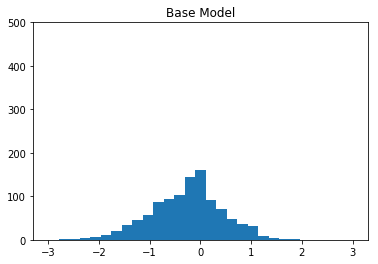

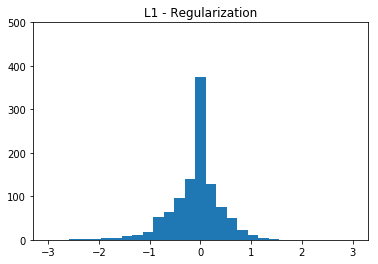

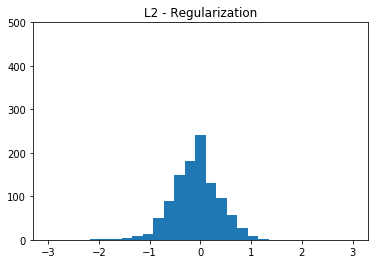

In [60]:
# Plot weight distribution graph
plt.figure()
_ = plt.hist(weights_base, bins=np.linspace(-3,3,30))
plt.title('Base Model')
plt.ylim([0,500])

plt.figure()
_ = plt.hist(weights_l1, bins=np.linspace(-3,3,30))
plt.title('L1 - Regularization')
plt.ylim([0,500])

plt.figure()
_ = plt.hist(weights_l2, bins=np.linspace(-3,3,30))
plt.title('L2 - Regularization')
_=plt.ylim([0,500])